In [17]:
#imports
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import plotly.io as pio

from helpers.datasetHelper import get_samples, split_data
from imblearn.over_sampling import SMOTE
from sklearn.metrics import cohen_kappa_score

from helpers.ploting import display_confusion_matrix_pink_variants
from helpers.metaheuristics import run_pso_with_progress, run_ga_with_progress
from models import MyXGboost
import numpy as np
from sklearn.metrics import recall_score, precision_score

# Update the import to match the actual function name in hiper_params_search.py
from hiper_params_search import get_best_xgboost

# Set the default renderer to 'browser' to ensure plots open in the browser
pio.renderers.default = 'browser'

In [18]:
directory_path_combined = './datasets/GEO-RAW'
# GSE32396_HEALTHY_BRCA = get_samples(os.path.join(directory_path_combined, 'GSE32396-HEALTHYxBRCA.csv'))
# GSE41037_HEALTHY = get_samples(os.path.join(directory_path_combined, 'GSE41037_HEALTHY.csv'))
GSE57285_HEALTHY_BRCA = get_samples(os.path.join(directory_path_combined, 'GSE57285_methylation.csv'))
# GSE58045_HEALTHY_UNK = get_samples(os.path.join(directory_path_combined, 'GSE58045-HEALTHY-UNK.csv'))
GSE32396_HEALTHY_BRCA = get_samples(os.path.join(directory_path_combined, 'GSE32396_methylation.csv'))
GSE58119_HEALTHY_PREBRCA = get_samples(os.path.join(directory_path_combined, 'GSE58119_methylation.csv'))

datasets_list = [
    GSE32396_HEALTHY_BRCA,
    # GSE41037_HEALTHY,
    GSE57285_HEALTHY_BRCA,
    # GSE58045_HEALTHY_UNK,
    GSE58119_HEALTHY_PREBRCA
]

tag_counts = {}
all_instances = []

for idx, dataset in enumerate(datasets_list):
    # Ignore the first column for all rows except the header
    tags = [row[1:] if i == 0 else row[-1] for i, row in enumerate(dataset)]
    # For header row, skip (do not count as tag)
    tags = [tag for tag in tags if not isinstance(tag, (np.ndarray, list))]
    unique_tags, counts = np.unique(tags, return_counts=True)
    print(f"Dataset {idx+1}:")
    for tag, count in zip(unique_tags, counts):
        print(f"  {tag}: {count}")
        tag_counts[tag] = tag_counts.get(tag, 0) + count
    print(f"  Total: {len(tags)}")
    # Add all rows except header, and ignore first column
    all_instances.extend([row[1:] for row in dataset[1:]])

print("\nConcatenated dataset:")
all_tags = [row[-1] for row in all_instances]
unique_tags_all, counts_all = np.unique(all_tags, return_counts=True)
for tag, count in zip(unique_tags_all, counts_all):
    print(f"  {tag}: {count}")
print(f"  Total: {len(all_tags)}")

Dataset 1:
  BRCA-MT: 15
  BRCA-WT: 15
  HEALTHY-MT: 15
  HEALTHY-WT: 15
  Total: 60
Dataset 2:
  BRCA-MT: 35
  HEALTHY-MT: 7
  HEALTHY-WT: 42
  Total: 84
Dataset 3:
  HEALTHY: 134
  PRE-BRCA: 148
  Total: 282

Concatenated dataset:
  BRCA-MT: 50
  BRCA-WT: 15
  HEALTHY: 134
  HEALTHY-MT: 22
  HEALTHY-WT: 57
  PRE-BRCA: 148
  Total: 426


In [19]:
healthy_mt_cases, healthy_wt_cases, healthy_unk_cases, prebrca_cases, brca_mt_cases, brca_wt_cases = split_data(all_instances)

healthy_mt_cases = pd.DataFrame(healthy_mt_cases)
healthy_wt_cases = pd.DataFrame(healthy_wt_cases)
healthy_unk_cases = pd.DataFrame(healthy_unk_cases)

prebrca_cases = pd.DataFrame(prebrca_cases)

brca_mt_cases = pd.DataFrame(brca_mt_cases)
brca_wt_cases = pd.DataFrame(brca_wt_cases)

healthy_consolidated_cases = pd.concat([healthy_mt_cases, healthy_wt_cases], ignore_index=True)
healthy_consolidated_cases['Tag'] = 'HEALTHY'
brca_consolidated_cases = pd.concat([brca_mt_cases, brca_wt_cases], ignore_index=True)
brca_consolidated_cases['Tag'] = 'BRCA'

healthy_mt_cases['Tag'] = 'HEALTHY-MT'
healthy_wt_cases['Tag'] = 'HEALTHY-WT'
healthy_unk_cases['Tag'] = 'HEALTHY-UNK'

prebrca_cases['Tag'] = 'PRE-BRCA'

brca_mt_cases['Tag'] = 'BRCA-MUT'
brca_wt_cases['Tag'] = 'BRCA-WT'

Performing PCA analysis...


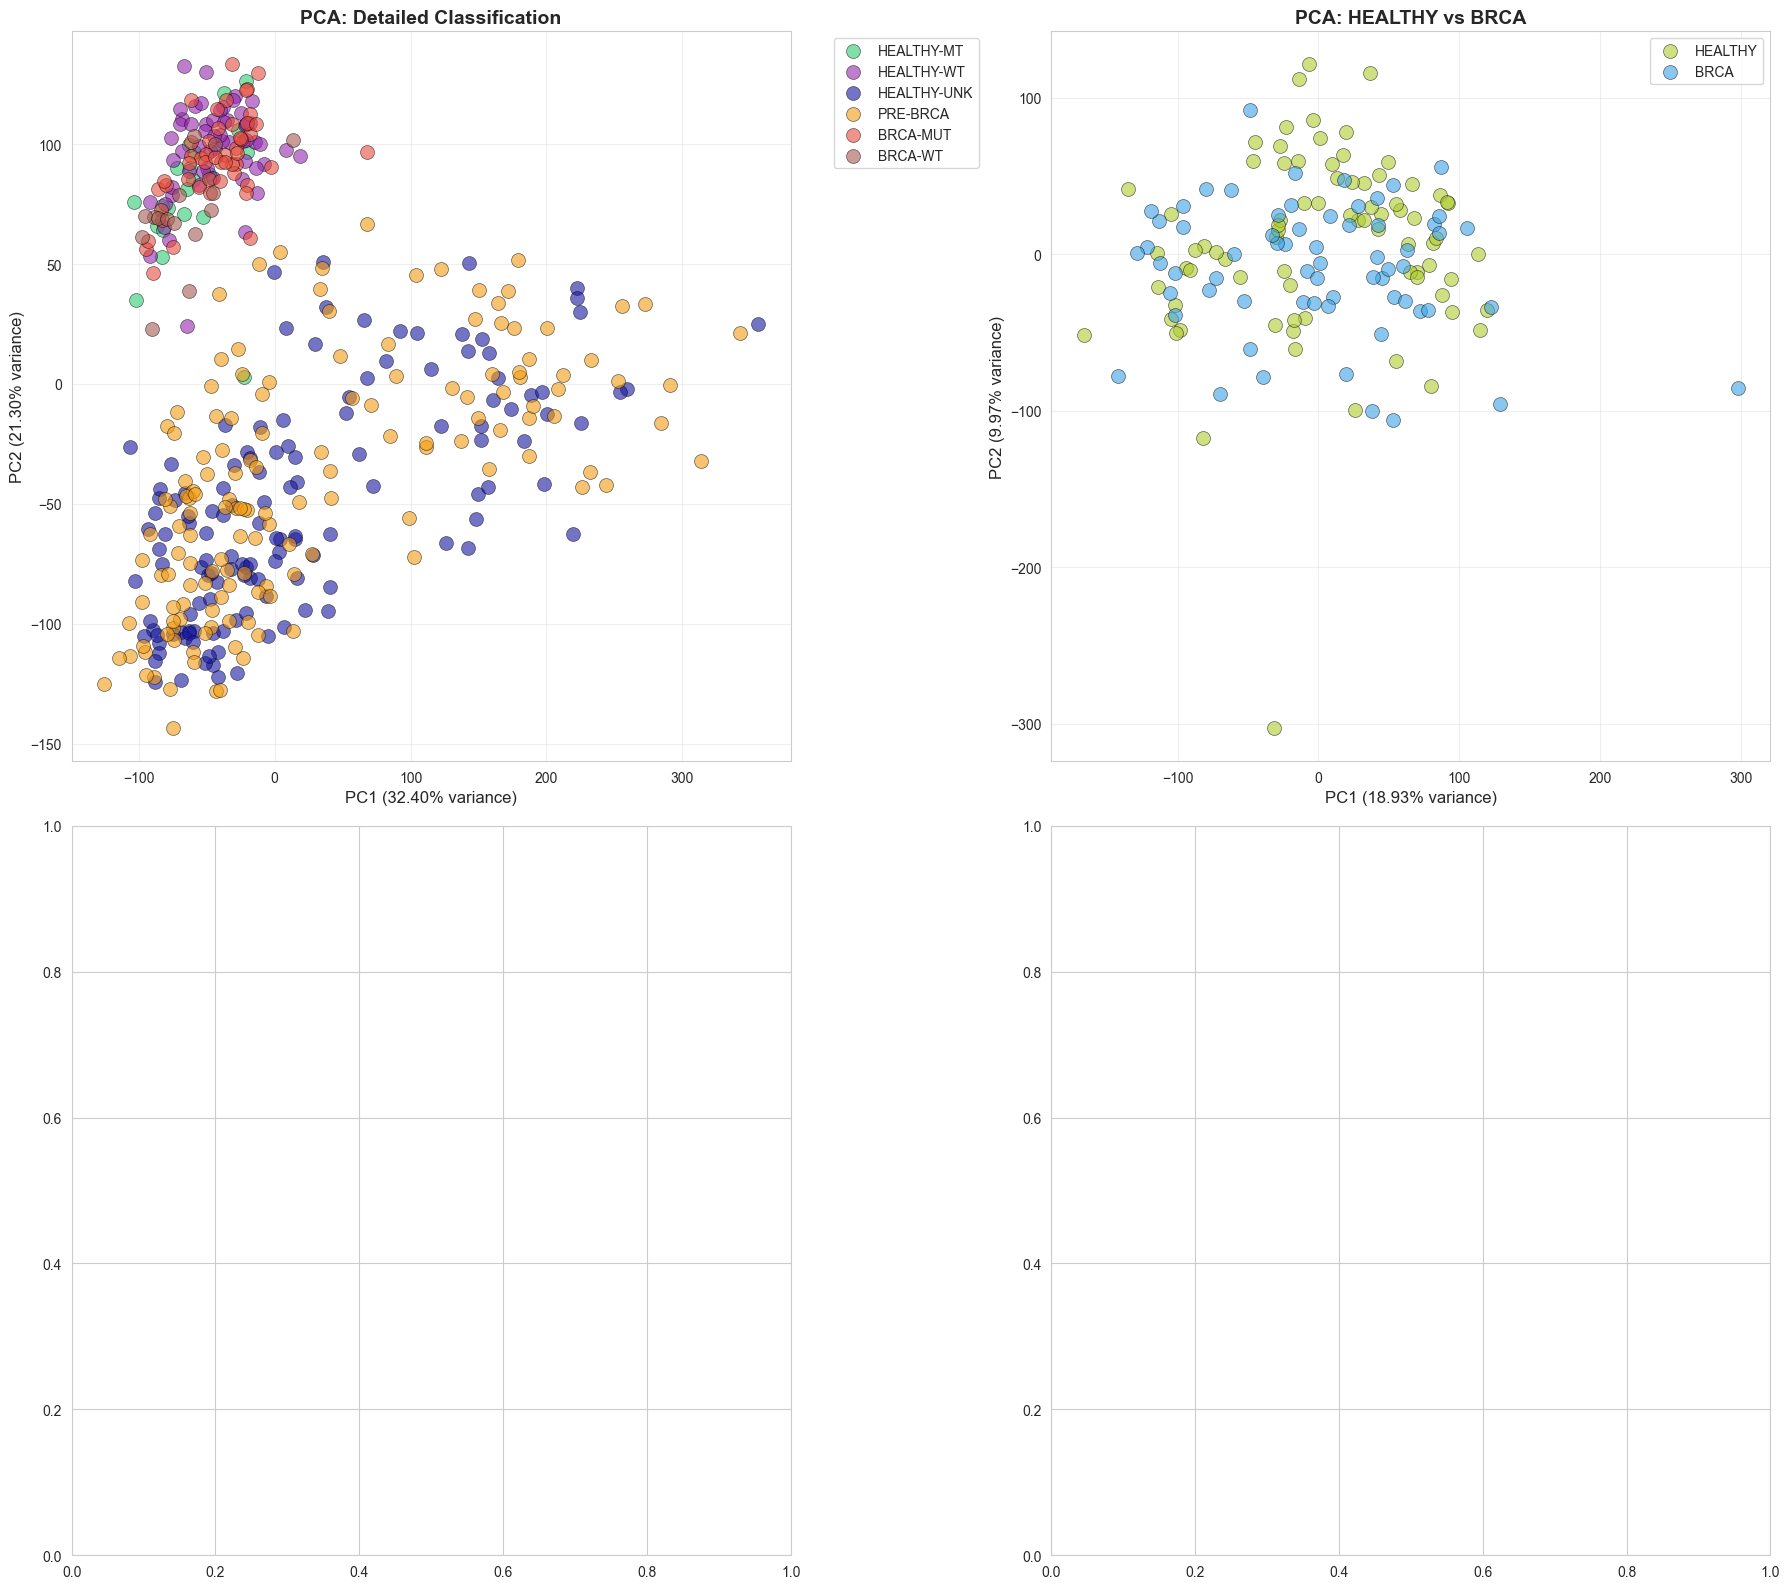

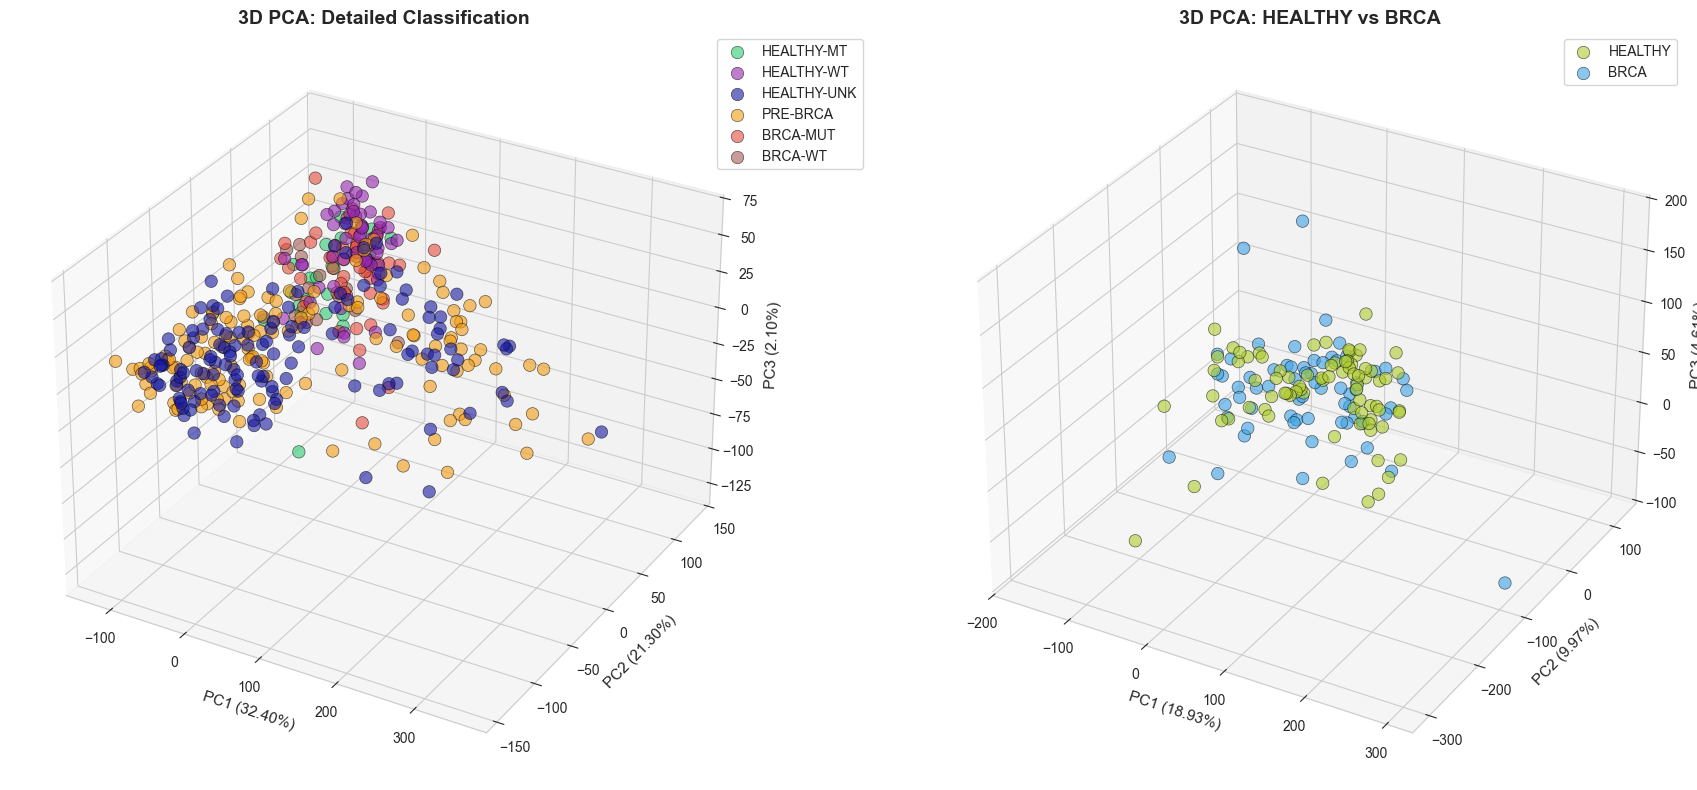

Performing t-SNE analysis (this may take a moment)...


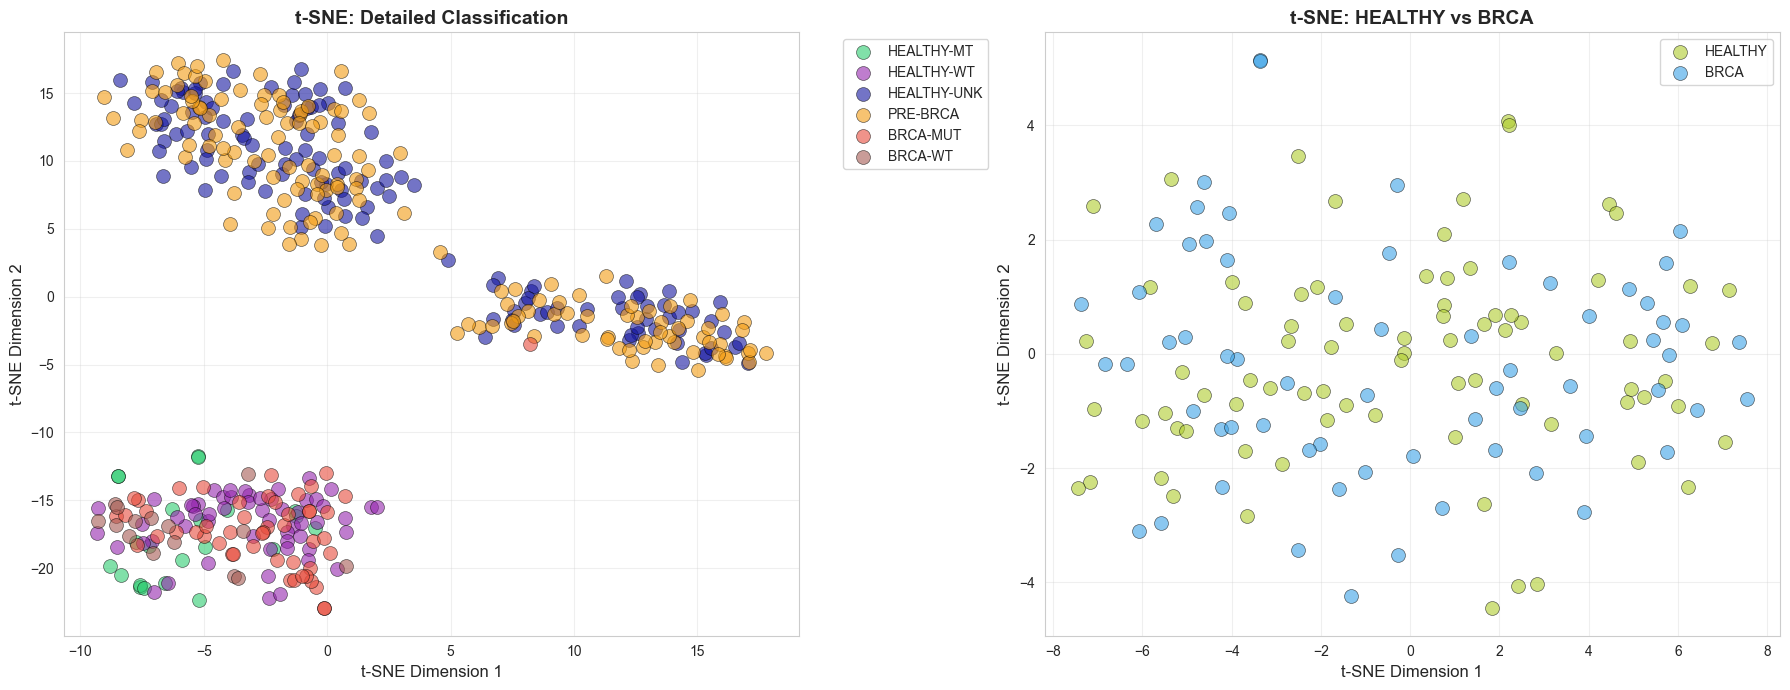

Performing hierarchical clustering...


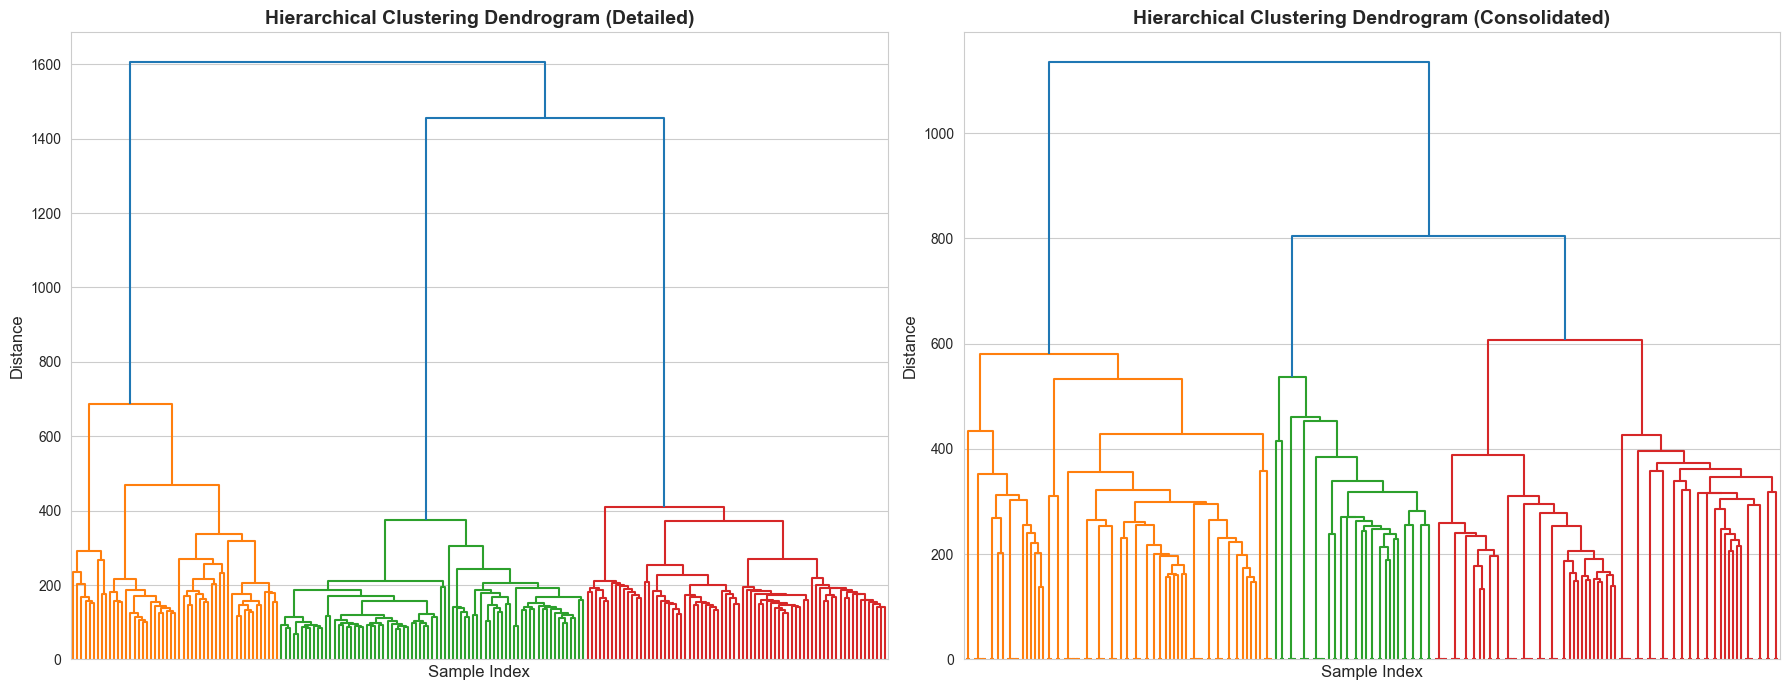

Performing K-Means elbow analysis...


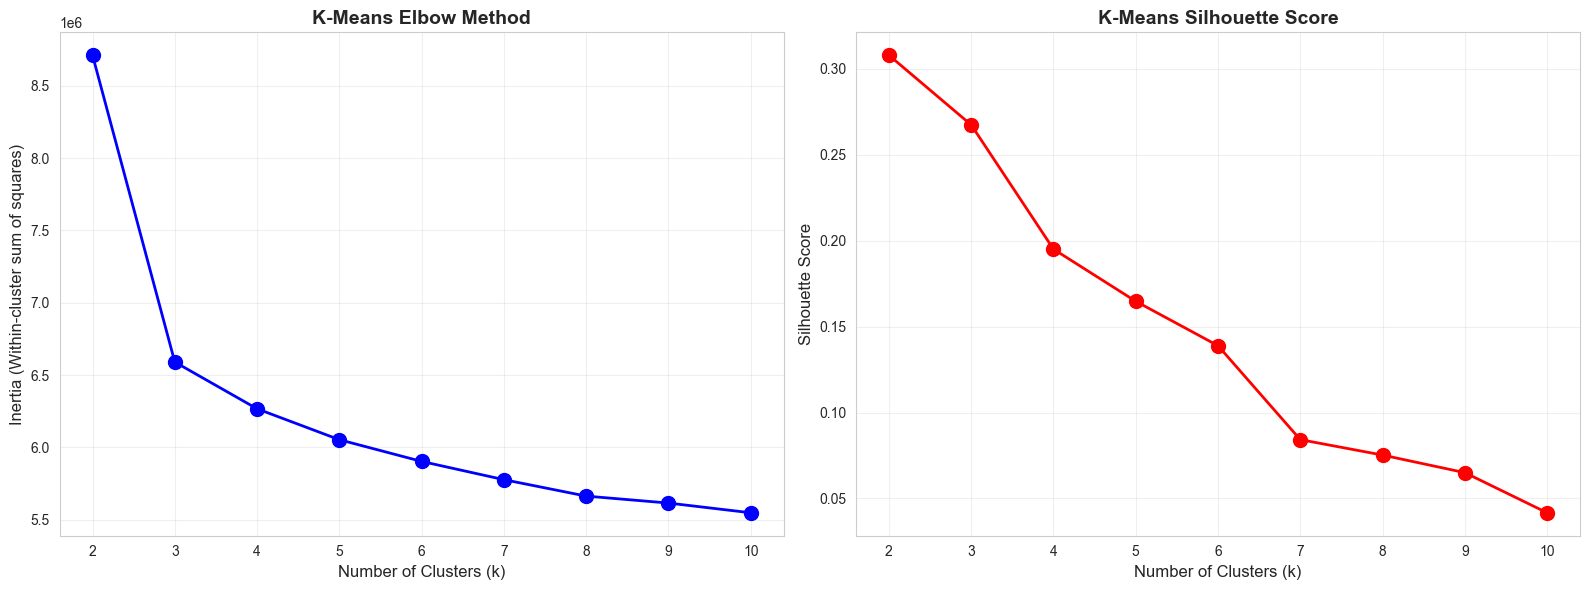

Creating pairwise scatter plots...


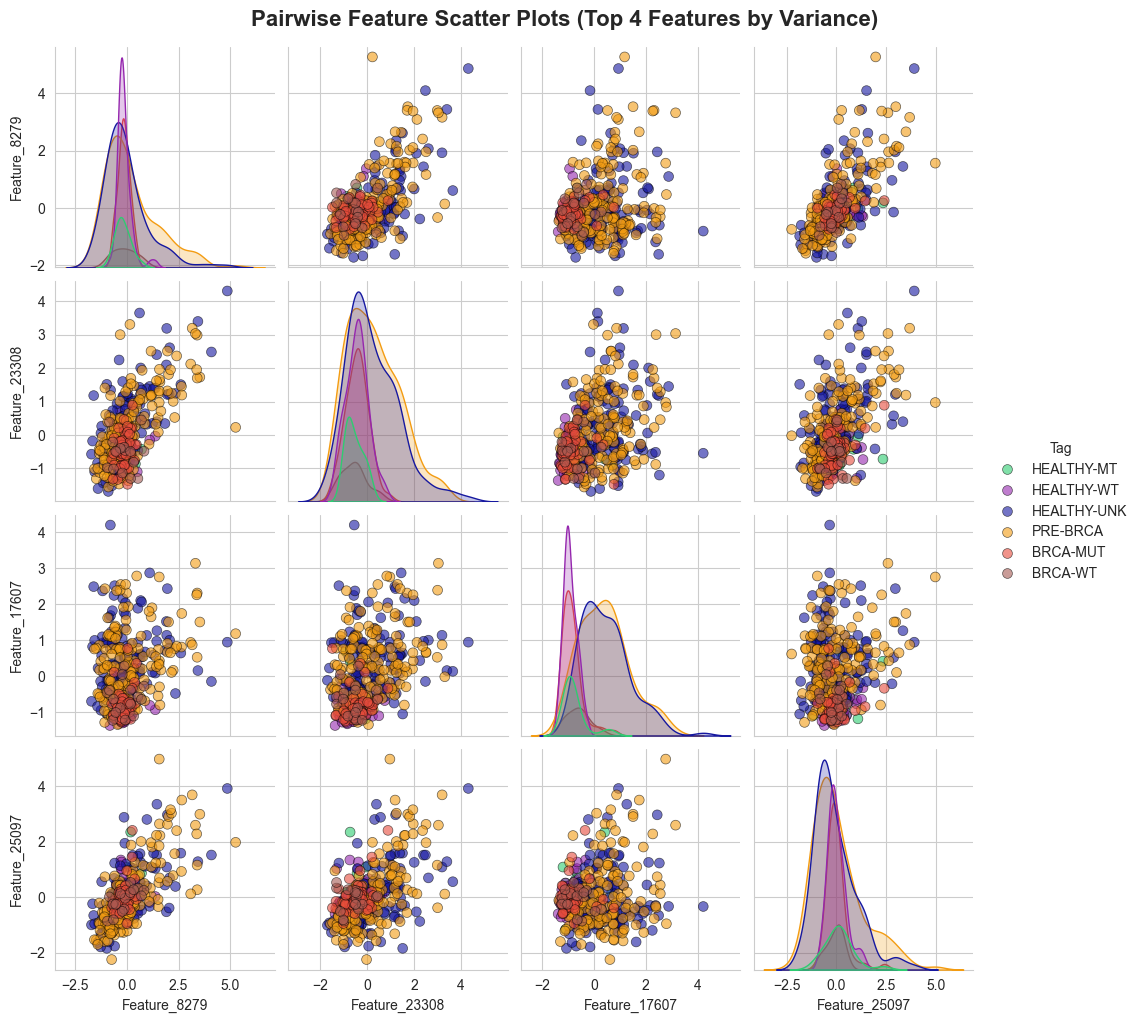


CLUSTER ANALYSIS SUMMARY

Dataset Size: 426 samples
Number of Features: 27578

Class Distribution:
Tag
PRE-BRCA       148
HEALTHY-UNK    134
HEALTHY-WT      57
BRCA-MUT        50
HEALTHY-MT      22
BRCA-WT         15

PCA - Top 2 Components Explain: 28.91% of variance
PCA - Top 3 Components Explain: 33.52% of variance

Optimal number of clusters (based on silhouette score): 2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Combine all datasets
all_data = pd.concat([
    healthy_mt_cases,
    healthy_wt_cases,
    healthy_unk_cases,
    prebrca_cases,
    brca_mt_cases,
    brca_wt_cases
], ignore_index=True)

# Also create consolidated version
consolidated_data = pd.concat([
    healthy_consolidated_cases,
    brca_consolidated_cases
], ignore_index=True)

# Separate features from tags
X = all_data.drop('Tag', axis=1)
y = all_data['Tag']

X_consolidated = consolidated_data.drop('Tag', axis=1)
y_consolidated = consolidated_data['Tag']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_consolidated_scaled = scaler.fit_transform(X_consolidated)

# Define color palette
color_map = {
    'HEALTHY-MT': '#2ecc71',
    'HEALTHY-WT': "#9527ae",
    'HEALTHY-UNK': "#1618a0",
    'PRE-BRCA': '#f39c12',
    'BRCA-MUT': '#e74c3c',
    'BRCA-WT': "#a55b53",
    'HEALTHY': "#afcc2e",
    'BRCA': "#3ca3e7"
}

# =============================================================================
# 1. PCA ANALYSIS (2D and 3D)
# =============================================================================
print("Performing PCA analysis...")

fig, axes = plt.subplots(2, 1, figsize=(18, 16))

# 2D PCA - Detailed tags
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

for tag in y.unique():
    mask = y == tag
    axes[0, 0].scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                       label=tag, alpha=0.6, s=100, 
                       c=color_map.get(tag, '#95a5a6'), edgecolors='black', linewidth=0.5)
axes[0, 0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
axes[0, 0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
axes[0, 0].set_title('PCA: Detailed Classification', fontsize=14, fontweight='bold')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# 2D PCA - Consolidated tags
X_pca_2d_cons = pca_2d.fit_transform(X_consolidated_scaled)

for tag in y_consolidated.unique():
    mask = y_consolidated == tag
    axes[0, 1].scatter(X_pca_2d_cons[mask, 0], X_pca_2d_cons[mask, 1], 
                       label=tag, alpha=0.6, s=100, 
                       c=color_map.get(tag, '#95a5a6'), edgecolors='black', linewidth=0.5)
axes[0, 1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
axes[0, 1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
axes[0, 1].set_title('PCA: HEALTHY vs BRCA', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Scree plot
# pca_full = PCA()
# pca_full.fit(X_scaled)
# axes[1, 0].plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
#                 np.cumsum(pca_full.explained_variance_ratio_), 'bo-', linewidth=2, markersize=8)
# axes[1, 0].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
# axes[1, 0].set_xlabel('Number of Components', fontsize=12)
# axes[1, 0].set_ylabel('Cumulative Explained Variance', fontsize=12)
# axes[1, 0].set_title('PCA Scree Plot', fontsize=14, fontweight='bold')
# axes[1, 0].legend()
# axes[1, 0].grid(True, alpha=0.3)

# # Variance per component
# axes[1, 1].bar(range(1, min(11, len(pca_full.explained_variance_ratio_) + 1)), 
#                pca_full.explained_variance_ratio_[:10], color='steelblue', edgecolor='black')
# axes[1, 1].set_xlabel('Principal Component', fontsize=12)
# axes[1, 1].set_ylabel('Explained Variance Ratio', fontsize=12)
# axes[1, 1].set_title('Variance Explained by Top 10 Components', fontsize=14, fontweight='bold')
# axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 3D PCA plot
fig = plt.figure(figsize=(18, 8))

# 3D PCA - Detailed
ax1 = fig.add_subplot(121, projection='3d')
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

for tag in y.unique():
    mask = y == tag
    ax1.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2],
                label=tag, alpha=0.6, s=80, c=color_map.get(tag, '#95a5a6'), 
                edgecolors='black', linewidth=0.5)
ax1.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})', fontsize=11)
ax1.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})', fontsize=11)
ax1.set_title('3D PCA: Detailed Classification', fontsize=14, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.15, 1))

# 3D PCA - Consolidated
ax2 = fig.add_subplot(122, projection='3d')
X_pca_3d_cons = pca_3d.fit_transform(X_consolidated_scaled)

for tag in y_consolidated.unique():
    mask = y_consolidated == tag
    ax2.scatter(X_pca_3d_cons[mask, 0], X_pca_3d_cons[mask, 1], X_pca_3d_cons[mask, 2],
                label=tag, alpha=0.6, s=80, c=color_map.get(tag, '#95a5a6'), 
                edgecolors='black', linewidth=0.5)
ax2.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})', fontsize=11)
ax2.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})', fontsize=11)
ax2.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})', fontsize=11)
ax2.set_title('3D PCA: HEALTHY vs BRCA', fontsize=14, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.savefig('pca_3d_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# 2. t-SNE ANALYSIS
# =============================================================================
print("Performing t-SNE analysis (this may take a moment)...")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# t-SNE - Detailed
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

for tag in y.unique():
    mask = y == tag
    axes[0].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                    label=tag, alpha=0.6, s=100, 
                    c=color_map.get(tag, '#95a5a6'), edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=12)
axes[0].set_title('t-SNE: Detailed Classification', fontsize=14, fontweight='bold')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# t-SNE - Consolidated
X_tsne_cons = tsne.fit_transform(X_consolidated_scaled)

for tag in y_consolidated.unique():
    mask = y_consolidated == tag
    axes[1].scatter(X_tsne_cons[mask, 0], X_tsne_cons[mask, 1], 
                    label=tag, alpha=0.6, s=100, 
                    c=color_map.get(tag, '#95a5a6'), edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=12)
axes[1].set_title('t-SNE: HEALTHY vs BRCA', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tsne_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# 3. HIERARCHICAL CLUSTERING
# =============================================================================
print("Performing hierarchical clustering...")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Hierarchical clustering - Detailed
sample_size = min(200, len(X_scaled))
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]
y_sample = y.iloc[sample_indices]

linkage_matrix = linkage(X_sample, method='ward')
dendro = dendrogram(linkage_matrix, ax=axes[0], no_labels=True, 
                    color_threshold=0.7*max(linkage_matrix[:,2]))
axes[0].set_title('Hierarchical Clustering Dendrogram (Detailed)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sample Index', fontsize=12)
axes[0].set_ylabel('Distance', fontsize=12)

# Hierarchical clustering - Consolidated
sample_indices_cons = np.random.choice(len(X_consolidated_scaled), sample_size, replace=True)
X_sample_cons = X_consolidated_scaled[sample_indices_cons]
y_sample_cons = y_consolidated.iloc[sample_indices_cons]

linkage_matrix_cons = linkage(X_sample_cons, method='ward')
dendro_cons = dendrogram(linkage_matrix_cons, ax=axes[1], no_labels=True,
                         color_threshold=0.7*max(linkage_matrix_cons[:,2]))
axes[1].set_title('Hierarchical Clustering Dendrogram (Consolidated)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sample Index', fontsize=12)
axes[1].set_ylabel('Distance', fontsize=12)

plt.tight_layout()
plt.savefig('hierarchical_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# 4. K-MEANS ELBOW METHOD
# =============================================================================
print("Performing K-Means elbow analysis...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=10)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0].set_title('K-Means Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=10)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('K-Means Silhouette Score', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('kmeans_elbow.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# 5. PAIRWISE FEATURE SCATTER PLOTS
# =============================================================================
print("Creating pairwise scatter plots...")

# Select top features based on variance
feature_variances = np.var(X_scaled, axis=0)
top_features = np.argsort(feature_variances)[-4:]  # Top 4 features

X_top = X_scaled[:, top_features]
df_plot = pd.DataFrame(X_top, columns=[f'Feature_{i}' for i in top_features])
df_plot['Tag'] = y.values

# Pairplot
g = sns.pairplot(df_plot, hue='Tag', palette=color_map, 
                 plot_kws={'alpha': 0.6, 's': 50, 'edgecolor': 'black', 'linewidth': 0.5},
                 diag_kind='kde', corner=False)
g.fig.suptitle('Pairwise Feature Scatter Plots (Top 4 Features by Variance)', 
               y=1.02, fontsize=16, fontweight='bold')
plt.savefig('pairwise_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# 6. SUMMARY STATISTICS
# =============================================================================
print("\n" + "="*70)
print("CLUSTER ANALYSIS SUMMARY")
print("="*70)
print(f"\nDataset Size: {len(all_data)} samples")
print(f"Number of Features: {X.shape[1]}")
print(f"\nClass Distribution:")
print(y.value_counts().to_string())
print(f"\nPCA - Top 2 Components Explain: {sum(pca_2d.explained_variance_ratio_):.2%} of variance")
print(f"PCA - Top 3 Components Explain: {sum(pca_3d.explained_variance_ratio_):.2%} of variance")
print(f"\nOptimal number of clusters (based on silhouette score): {K_range[np.argmax(silhouette_scores)]}")
print("="*70)

PREPARING DATA FOR 3-CLASS CLASSIFICATION

Dataset shape: (426, 27578)
Features: 27578
Samples: 426

Class distribution:
Target
HEALTHY     213
PRE-BRCA    148
BRCA         65
Name: count, dtype: int64

Class percentages:
Target
HEALTHY     50.000000
PRE-BRCA    34.741784
BRCA        15.258216
Name: proportion, dtype: float64

Training set size: 340
Test set size: 86

FEATURE SELECTION

ANOVA F-test selected 100 features
Random Forest selected top 100 features by importance


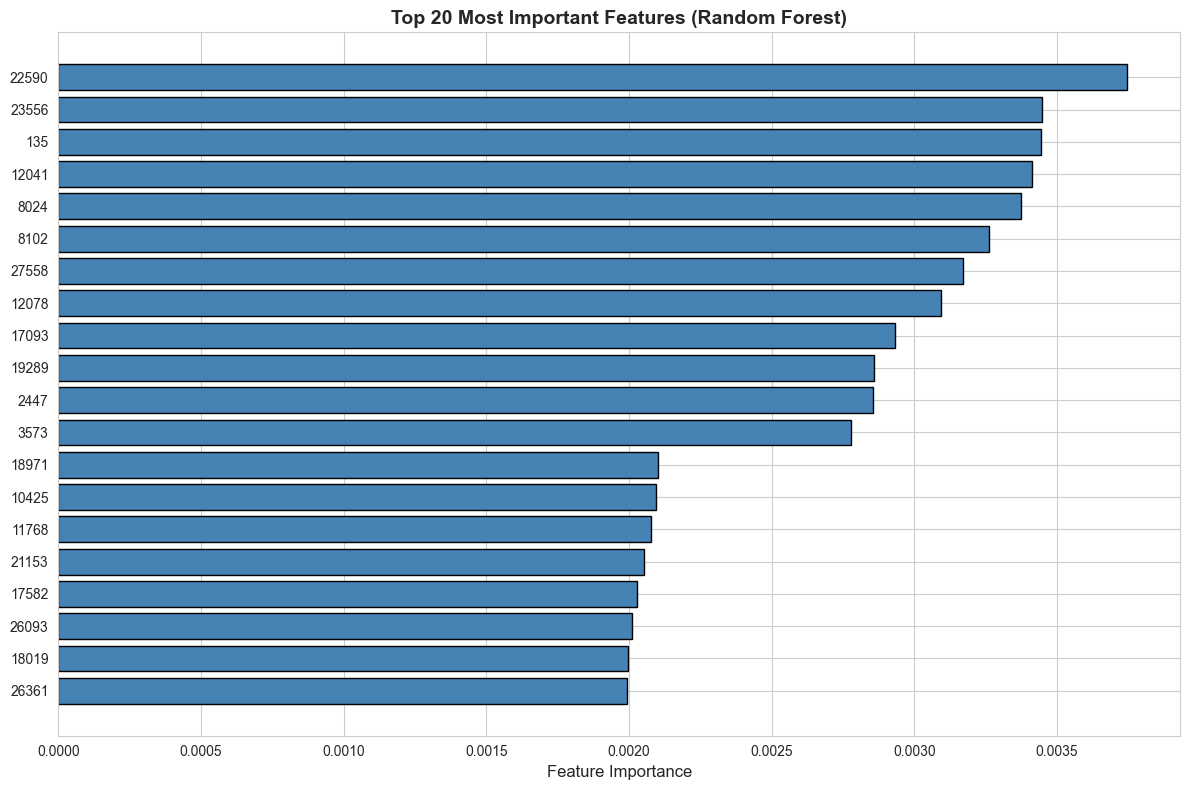


TRAINING MULTIPLE MODELS

Training Random Forest...
Accuracy: 0.4651
Cohen's Kappa: 0.1250
Macro F1-Score: 0.4766
Weighted F1-Score: 0.4647
F1-Score BRCA: 0.5185
F1-Score HEALTHY: 0.4524
F1-Score PRE-BRCA: 0.4590
CV Accuracy: 0.5471 (+/- 0.0775)

Training Gradient Boosting...
Accuracy: 0.5349
Cohen's Kappa: 0.2448
Macro F1-Score: 0.5393
Weighted F1-Score: 0.5345
F1-Score BRCA: 0.5517
F1-Score HEALTHY: 0.5238
F1-Score PRE-BRCA: 0.5424
CV Accuracy: 0.5618 (+/- 0.0513)

Training SVM (RBF)...
Accuracy: 0.5814
Cohen's Kappa: 0.3636
Macro F1-Score: 0.5886
Weighted F1-Score: 0.5629
F1-Score BRCA: 0.6286
F1-Score HEALTHY: 0.4706
F1-Score PRE-BRCA: 0.6667
CV Accuracy: 0.5765 (+/- 0.0598)

Training Neural Network...


/Users/leandro/Lab/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/leandro/Lab/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/leandro/Lab/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/leandro/Lab/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/leandro/Lab/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/leandro/Lab/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered 

Accuracy: 0.5814
Cohen's Kappa: 0.3326
Macro F1-Score: 0.5872
Weighted F1-Score: 0.5650
F1-Score BRCA: 0.7027
F1-Score HEALTHY: 0.5909
F1-Score PRE-BRCA: 0.4681
CV Accuracy: 0.6206 (+/- 0.0569)

Training Logistic Regression...
Accuracy: 0.6047
Cohen's Kappa: 0.3870
Macro F1-Score: 0.6146
Weighted F1-Score: 0.5970
F1-Score BRCA: 0.6471
F1-Score HEALTHY: 0.5405
F1-Score PRE-BRCA: 0.6562
CV Accuracy: 0.5706 (+/- 0.0388)

CREATING ENSEMBLE MODEL


/Users/leandro/Lab/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/leandro/Lab/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/leandro/Lab/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/leandro/Lab/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/leandro/Lab/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/leandro/Lab/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered 


Ensemble Accuracy: 0.5349
Ensemble Cohen's Kappa: 0.2361
Ensemble Macro F1-Score: 0.5354
Ensemble Weighted F1-Score: 0.5337
Ensemble F1-Score BRCA: 0.5517
Ensemble F1-Score HEALTHY: 0.5455
Ensemble F1-Score PRE-BRCA: 0.5091
Ensemble CV Accuracy: 0.6088 (+/- 0.0635)

MODEL COMPARISON SUMMARY

               Model  Accuracy  Cohens Kappa  Macro F1  Weighted F1  F1 BRCA  F1 HEALTHY  F1 PRE-BRCA  CV Mean   CV Std
Logistic Regression  0.604651      0.387002  0.614616     0.597006 0.647059    0.540541     0.656250 0.570588 0.038797
          SVM (RBF)  0.581395      0.363618  0.588609     0.562869 0.628571    0.470588     0.666667 0.576471 0.059844
     Neural Network  0.581395      0.332615  0.587232     0.564963 0.702703    0.590909     0.468085 0.620588 0.056880
  Gradient Boosting  0.534884      0.244786  0.539302     0.534505 0.551724    0.523810     0.542373 0.561765 0.051281
  Ensemble (Voting)  0.534884      0.236065  0.535423     0.533717 0.551724    0.545455     0.509091 0.608824 

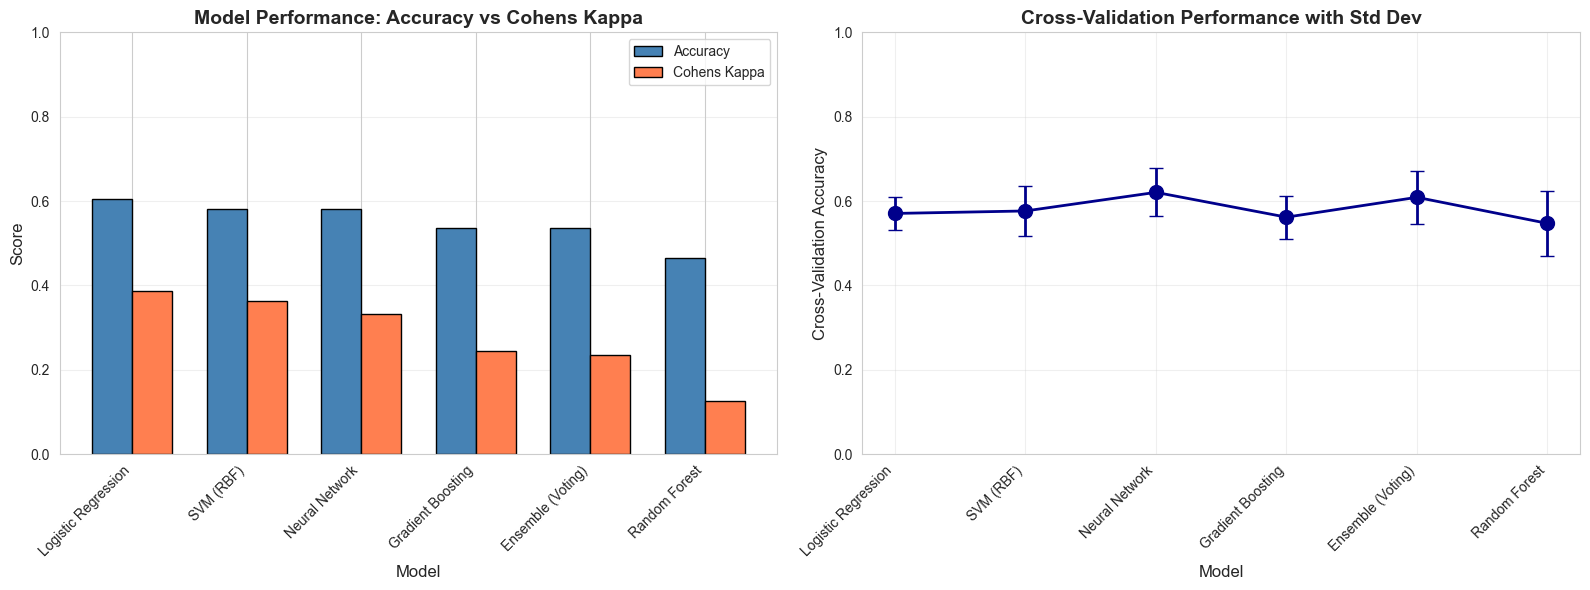

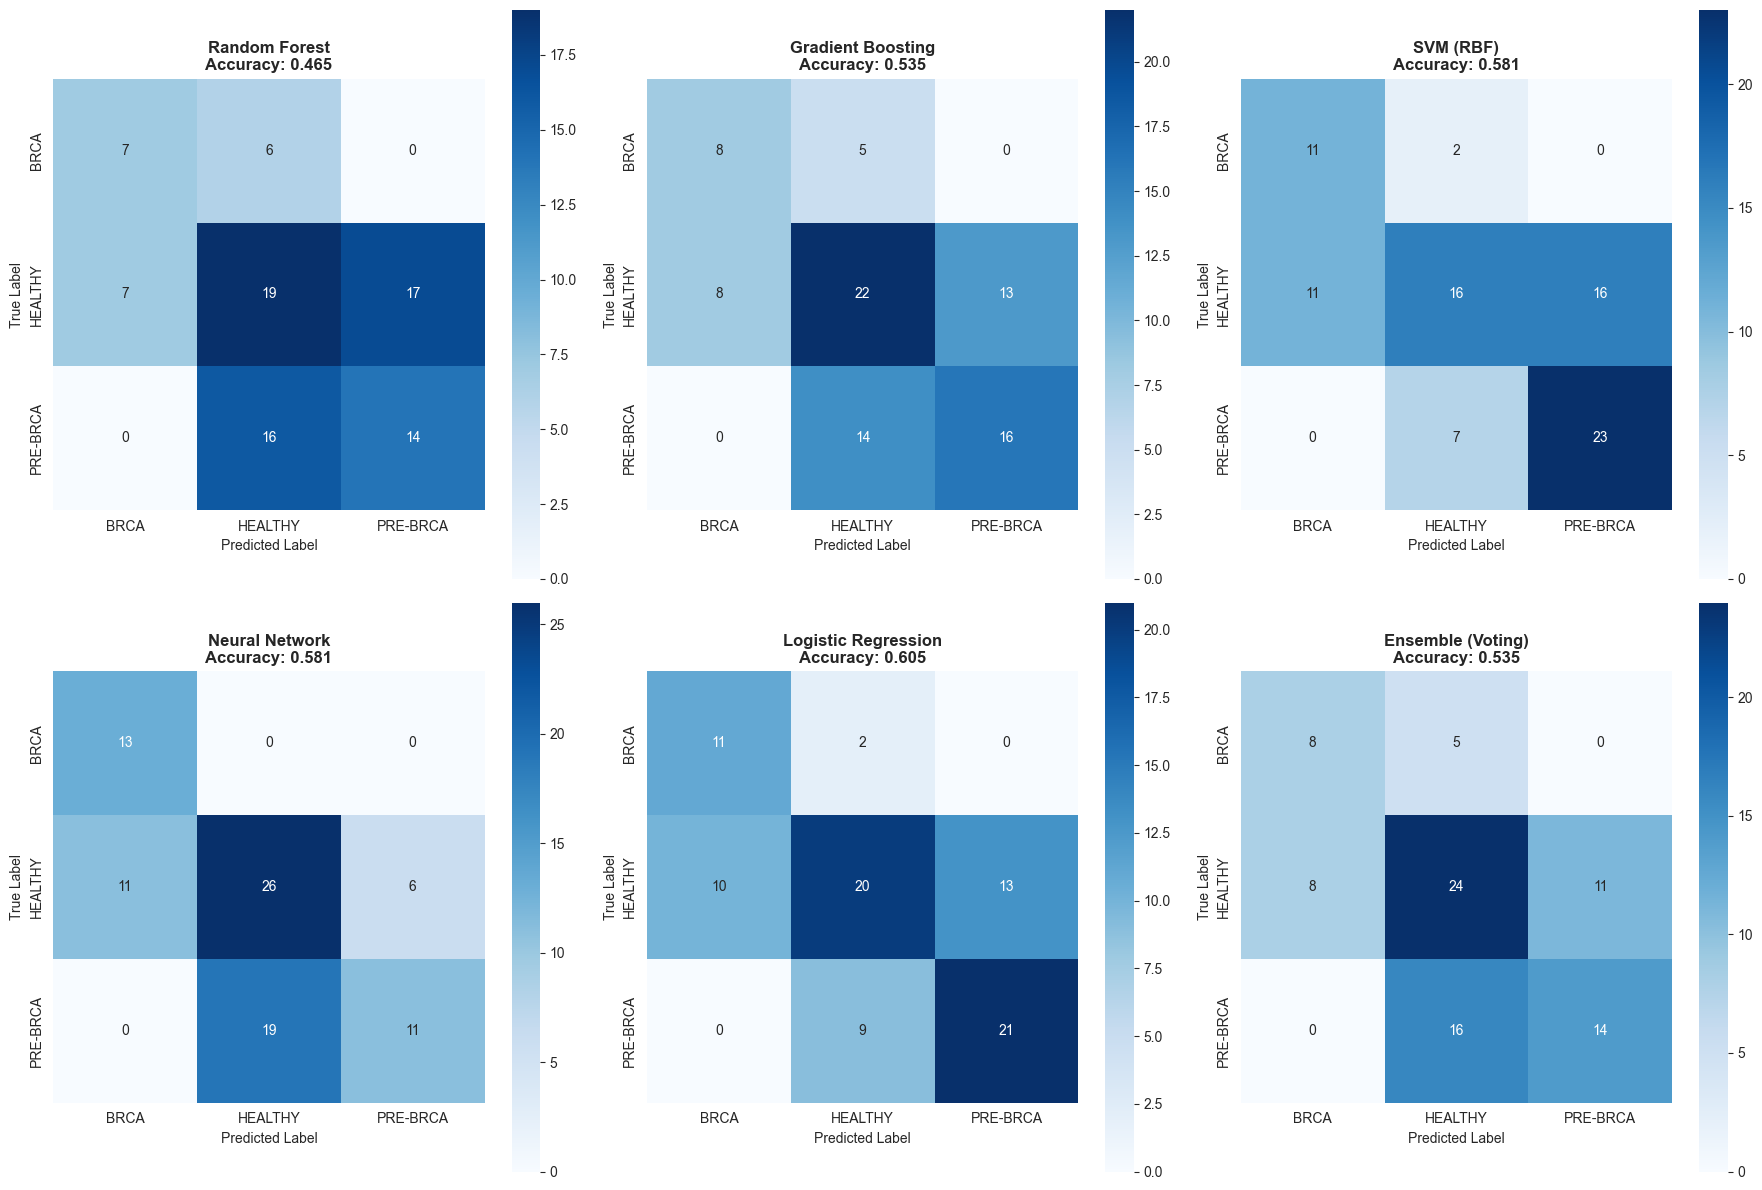

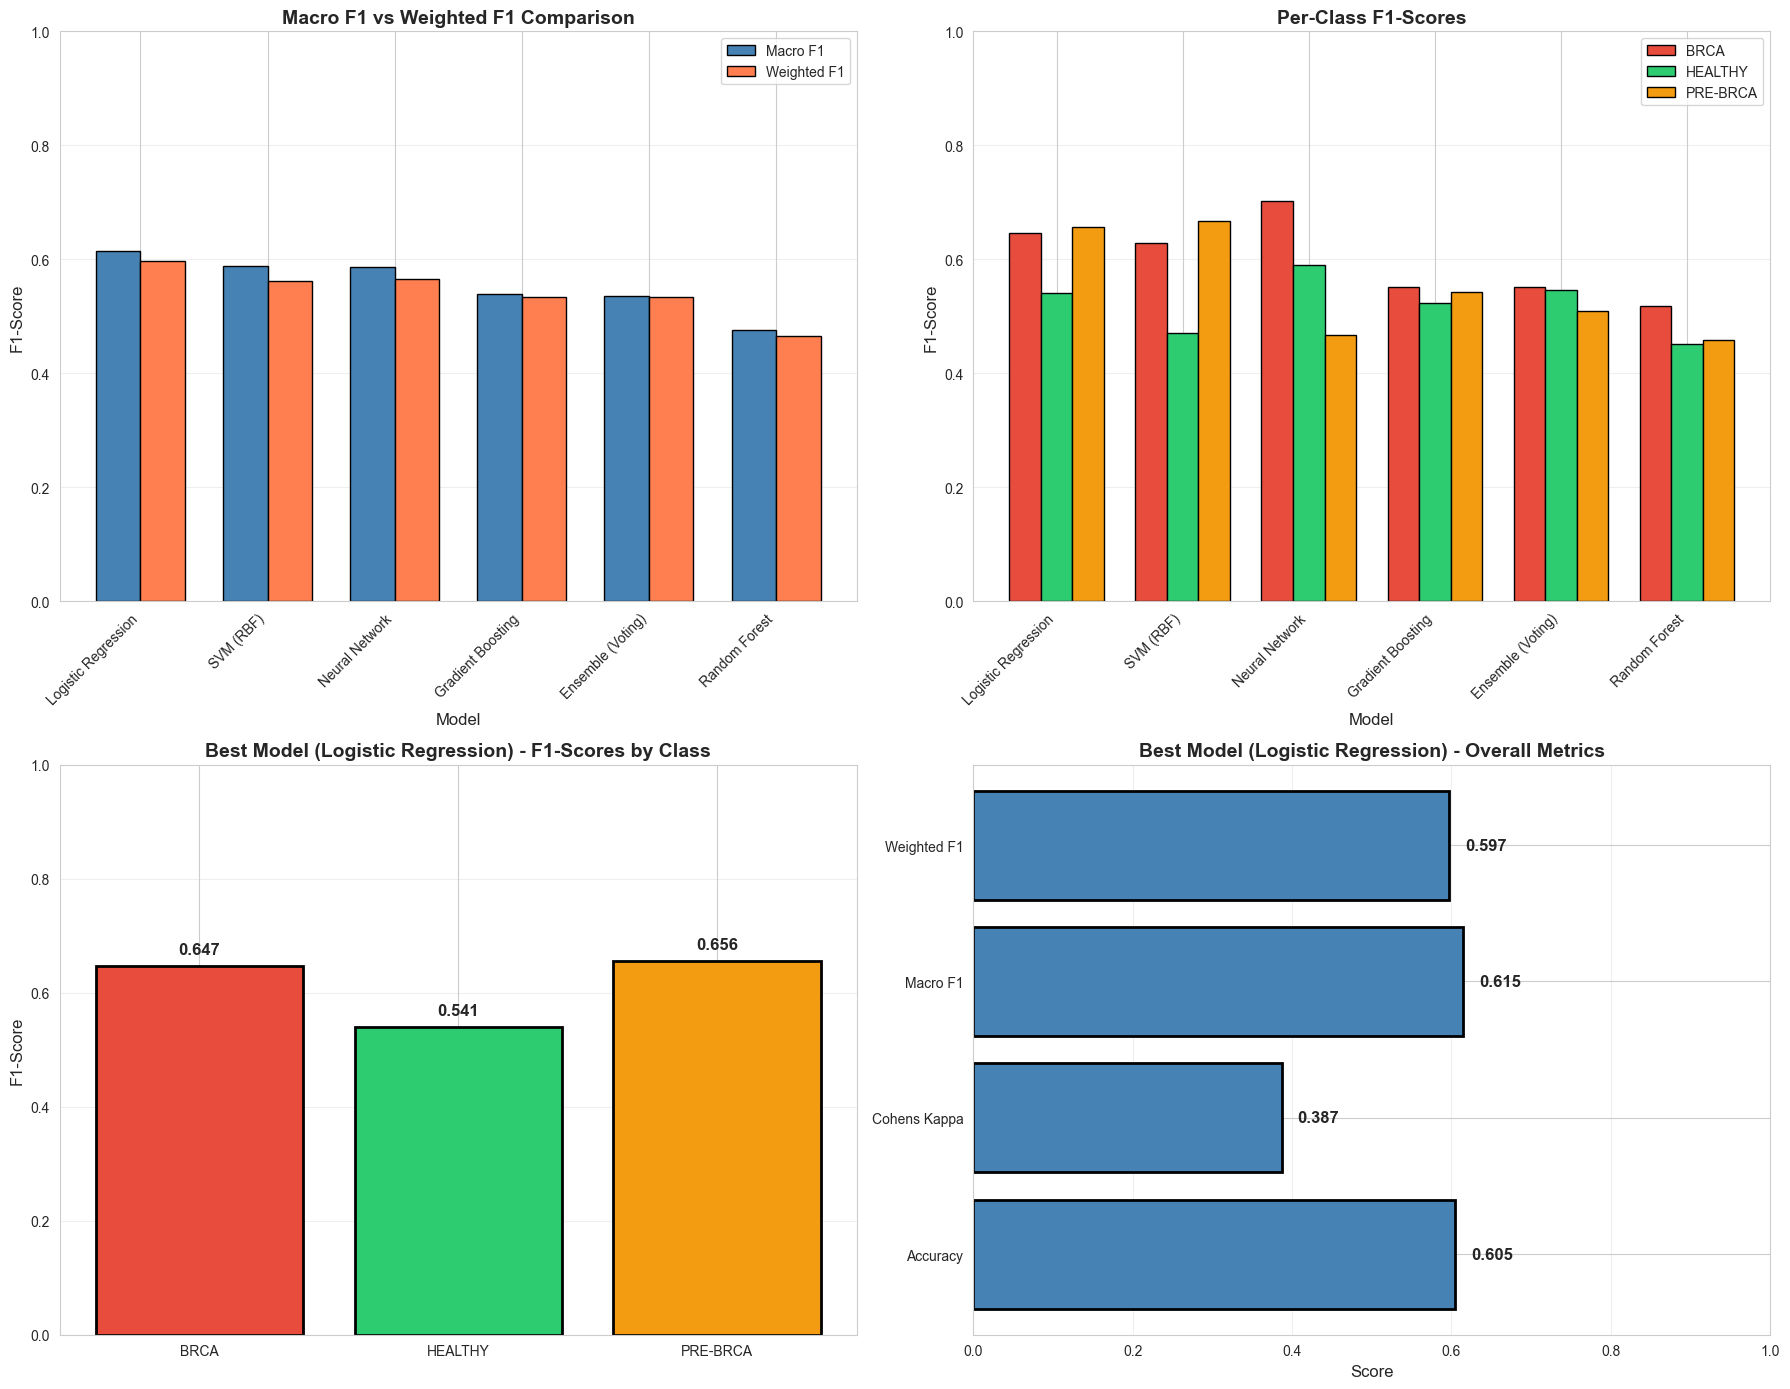


DETAILED CLASSIFICATION REPORT - Logistic Regression

Accuracy:          0.6047
Cohen's Kappa:     0.3870
Macro F1-Score:    0.6146
Weighted F1-Score: 0.5970
F1-Score BRCA:     0.6471
F1-Score HEALTHY:  0.5405
F1-Score PRE-BRCA: 0.6562

              precision    recall  f1-score   support

        BRCA       0.52      0.85      0.65        13
     HEALTHY       0.65      0.47      0.54        43
    PRE-BRCA       0.62      0.70      0.66        30

    accuracy                           0.60        86
   macro avg       0.60      0.67      0.61        86
weighted avg       0.62      0.60      0.60        86



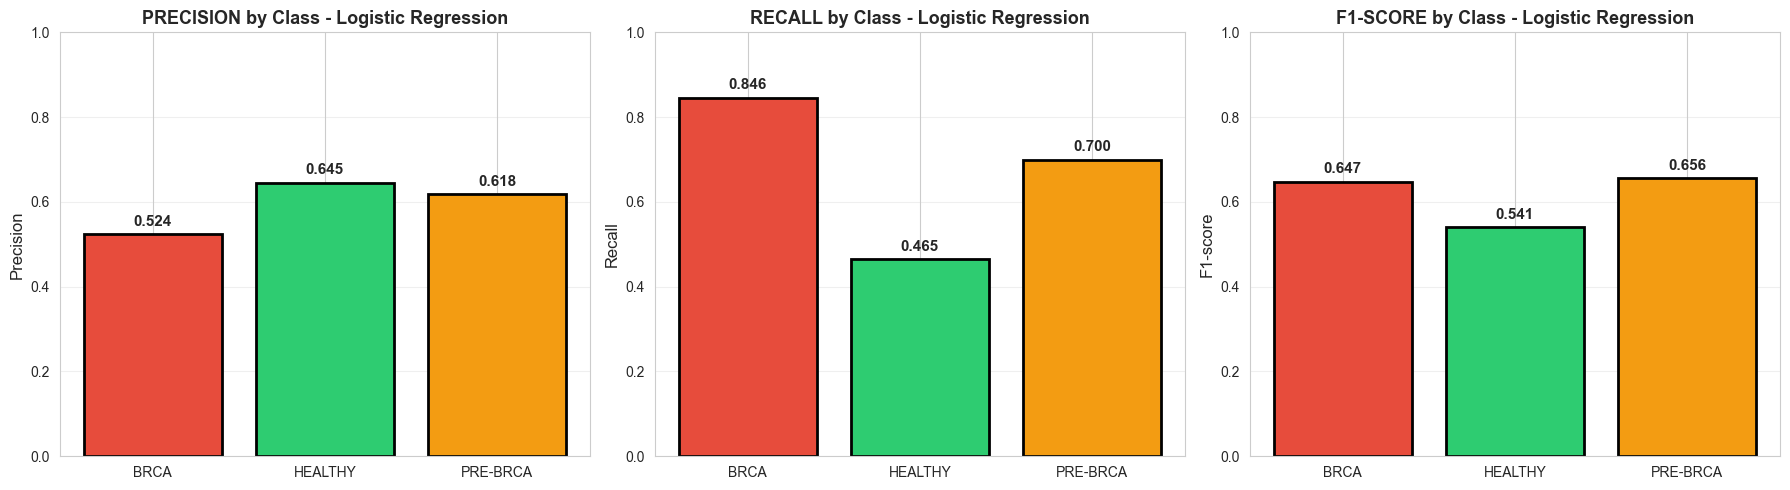

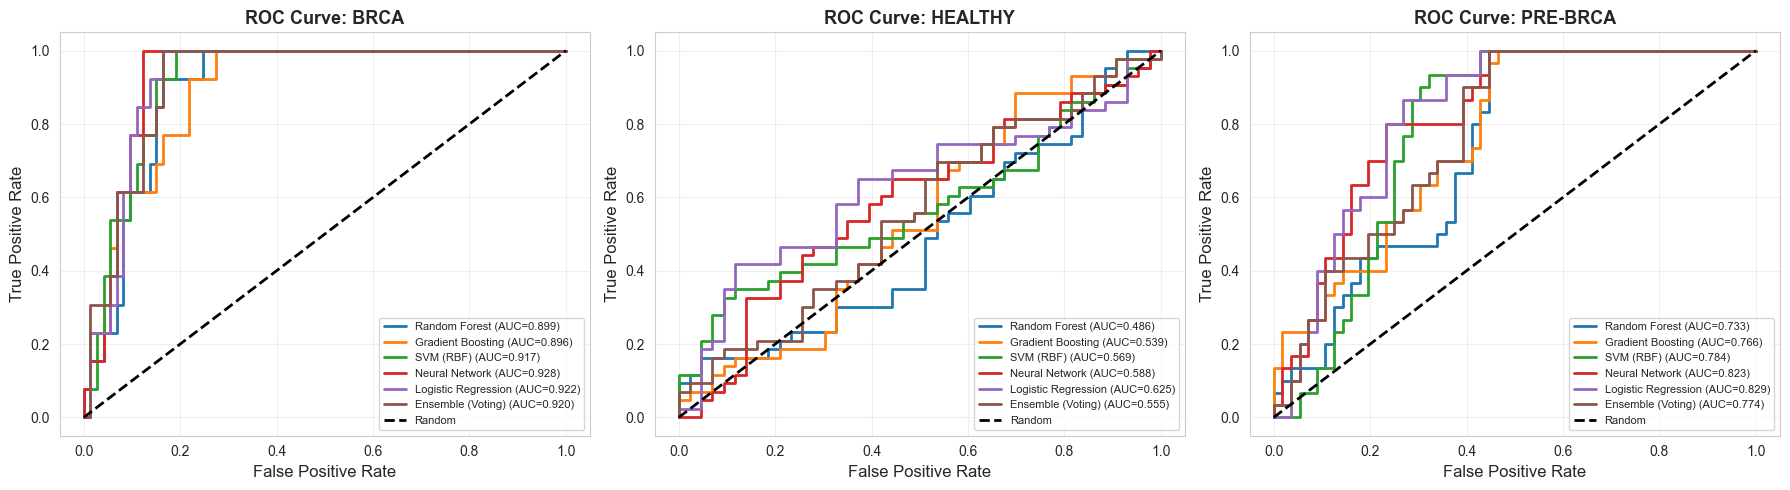


SAVING BEST MODEL AND PREPROCESSING OBJECTS

Best model saved as 'best_classification_model.pkl'
Model: Logistic Regression
Accuracy:          0.6047
Cohen's Kappa:     0.3870
Macro F1-Score:    0.6146
Weighted F1-Score: 0.5970
F1-Score BRCA:     0.6471
F1-Score HEALTHY:  0.5405
F1-Score PRE-BRCA: 0.6562

CREATING PREDICTION FUNCTION

Prediction function created successfully!
Use predict_new_sample(your_data) to classify new samples

EXAMPLE PREDICTION

Sample prediction:
Predicted Class: HEALTHY
Confidence: 0.6321
Probabilities:
  BRCA: 0.0002
  HEALTHY: 0.6321
  PRE-BRCA: 0.3677

CLASSIFICATION PIPELINE COMPLETE


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, roc_auc_score, roc_curve, auc,
                             cohen_kappa_score, f1_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# =============================================================================
# 1. DATA PREPARATION
# =============================================================================
print("="*70)
print("PREPARING DATA FOR 3-CLASS CLASSIFICATION")
print("="*70)

# Combine data into 3 groups
healthy_all = pd.concat([healthy_mt_cases, healthy_wt_cases, healthy_unk_cases], 
                        ignore_index=True)
healthy_all['Target'] = 'HEALTHY'

prebrca_all = prebrca_cases.copy()
prebrca_all['Target'] = 'PRE-BRCA'

brca_all = pd.concat([brca_mt_cases, brca_wt_cases], ignore_index=True)
brca_all['Target'] = 'BRCA'

# Combine all data
all_data = pd.concat([healthy_all, prebrca_all, brca_all], ignore_index=True)

# Separate features and target
X = all_data.drop(['Target', 'Tag'], axis=1, errors='ignore')
y = all_data['Target']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nDataset shape: {X.shape}")
print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")
print(f"\nClass distribution:")
print(y.value_counts())
print(f"\nClass percentages:")
print(y.value_counts(normalize=True) * 100)

# =============================================================================
# 2. TRAIN-TEST SPLIT
# =============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =============================================================================
# 3. FEATURE SELECTION
# =============================================================================
print("\n" + "="*70)
print("FEATURE SELECTION")
print("="*70)

# Method 1: SelectKBest with ANOVA F-test
selector_anova = SelectKBest(f_classif, k=min(100, X.shape[1]))
X_train_selected_anova = selector_anova.fit_transform(X_train_scaled, y_train)
X_test_selected_anova = selector_anova.transform(X_test_scaled)

selected_features_anova = X.columns[selector_anova.get_support()].tolist()
print(f"\nANOVA F-test selected {len(selected_features_anova)} features")

# Method 2: Random Forest feature importance
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train_scaled, y_train)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

top_100_features = feature_importance.head(100)['feature'].tolist()
feature_indices = [X.columns.get_loc(f) for f in top_100_features]
X_train_selected_rf = X_train_scaled[:, feature_indices]
X_test_selected_rf = X_test_scaled[:, feature_indices]

print(f"Random Forest selected top 100 features by importance")

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'], color='steelblue', edgecolor='black')
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 20 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# 4. MODEL TRAINING
# =============================================================================
print("\n" + "="*70)
print("TRAINING MULTIPLE MODELS")
print("="*70)

# Define models
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200, 
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42, 
        n_jobs=-1,
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),
    'SVM (RBF)': SVC(
        kernel='rbf',
        C=10,
        gamma='scale',
        probability=True,
        random_state=42,
        class_weight='balanced'
    ),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        alpha=0.001,
        batch_size=32,
        learning_rate='adaptive',
        max_iter=500,
        random_state=42,
        early_stopping=True
    ),
    'Logistic Regression': LogisticRegression(
        C=1.0,
        max_iter=1000,
        random_state=42,
        class_weight='balanced',
        multi_class='multinomial'
    )
}

# Train and evaluate models
results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use RF-selected features for better performance
    model.fit(X_train_selected_rf, y_train)
    y_pred = model.predict(X_test_selected_rf)
    y_pred_proba = model.predict_proba(X_test_selected_rf)
    
    # Calculate all required metrics
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Per-class F1 scores
    f1_per_class = f1_score(y_test, y_pred, average=None)
    f1_brca = f1_per_class[le.transform(['BRCA'])[0]]
    f1_healthy = f1_per_class[le.transform(['HEALTHY'])[0]]
    f1_prebrca = f1_per_class[le.transform(['PRE-BRCA'])[0]]
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_selected_rf, y_train, 
                                cv=cv, scoring='accuracy', n_jobs=-1)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'kappa': kappa,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'f1_brca': f1_brca,
        'f1_healthy': f1_healthy,
        'f1_prebrca': f1_prebrca,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'classification_report': classification_report(y_test, y_pred, 
                                                       target_names=le.classes_,
                                                       output_dict=True)
    }
    trained_models[name] = model
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Macro F1-Score: {macro_f1:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")
    print(f"F1-Score BRCA: {f1_brca:.4f}")
    print(f"F1-Score HEALTHY: {f1_healthy:.4f}")
    print(f"F1-Score PRE-BRCA: {f1_prebrca:.4f}")
    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# =============================================================================
# 5. ENSEMBLE MODEL
# =============================================================================
print("\n" + "="*70)
print("CREATING ENSEMBLE MODEL")
print("="*70)

# Create voting classifier with best models
voting_clf = VotingClassifier(
    estimators=[
        ('rf', models['Random Forest']),
        ('gb', models['Gradient Boosting']),
        ('svm', models['SVM (RBF)']),
        ('nn', models['Neural Network'])
    ],
    voting='soft',
    n_jobs=-1
)

voting_clf.fit(X_train_selected_rf, y_train)
y_pred_ensemble = voting_clf.predict(X_test_selected_rf)
y_pred_proba_ensemble = voting_clf.predict_proba(X_test_selected_rf)

# Calculate all metrics for ensemble
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
kappa_ensemble = cohen_kappa_score(y_test, y_pred_ensemble)
macro_f1_ensemble = f1_score(y_test, y_pred_ensemble, average='macro')
weighted_f1_ensemble = f1_score(y_test, y_pred_ensemble, average='weighted')

# Per-class F1 scores
f1_per_class_ensemble = f1_score(y_test, y_pred_ensemble, average=None)
f1_brca_ensemble = f1_per_class_ensemble[le.transform(['BRCA'])[0]]
f1_healthy_ensemble = f1_per_class_ensemble[le.transform(['HEALTHY'])[0]]
f1_prebrca_ensemble = f1_per_class_ensemble[le.transform(['PRE-BRCA'])[0]]

cv_scores_ensemble = cross_val_score(voting_clf, X_train_selected_rf, y_train,
                                     cv=cv, scoring='accuracy', n_jobs=-1)

results['Ensemble (Voting)'] = {
    'model': voting_clf,
    'accuracy': accuracy_ensemble,
    'kappa': kappa_ensemble,
    'macro_f1': macro_f1_ensemble,
    'weighted_f1': weighted_f1_ensemble,
    'f1_brca': f1_brca_ensemble,
    'f1_healthy': f1_healthy_ensemble,
    'f1_prebrca': f1_prebrca_ensemble,
    'cv_mean': cv_scores_ensemble.mean(),
    'cv_std': cv_scores_ensemble.std(),
    'y_pred': y_pred_ensemble,
    'y_pred_proba': y_pred_proba_ensemble,
    'classification_report': classification_report(y_test, y_pred_ensemble,
                                                   target_names=le.classes_,
                                                   output_dict=True)
}

print(f"\nEnsemble Accuracy: {accuracy_ensemble:.4f}")
print(f"Ensemble Cohen's Kappa: {kappa_ensemble:.4f}")
print(f"Ensemble Macro F1-Score: {macro_f1_ensemble:.4f}")
print(f"Ensemble Weighted F1-Score: {weighted_f1_ensemble:.4f}")
print(f"Ensemble F1-Score BRCA: {f1_brca_ensemble:.4f}")
print(f"Ensemble F1-Score HEALTHY: {f1_healthy_ensemble:.4f}")
print(f"Ensemble F1-Score PRE-BRCA: {f1_prebrca_ensemble:.4f}")
print(f"Ensemble CV Accuracy: {cv_scores_ensemble.mean():.4f} (+/- {cv_scores_ensemble.std():.4f})")

# =============================================================================
# 6. MODEL COMPARISON
# =============================================================================
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Cohens Kappa': [results[m]['kappa'] for m in results.keys()],
    'Macro F1': [results[m]['macro_f1'] for m in results.keys()],
    'Weighted F1': [results[m]['weighted_f1'] for m in results.keys()],
    'F1 BRCA': [results[m]['f1_brca'] for m in results.keys()],
    'F1 HEALTHY': [results[m]['f1_healthy'] for m in results.keys()],
    'F1 PRE-BRCA': [results[m]['f1_prebrca'] for m in results.keys()],
    'CV Mean': [results[m]['cv_mean'] for m in results.keys()],
    'CV Std': [results[m]['cv_std'] for m in results.keys()]
})
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
print("\n", comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_results = results[best_model_name]

print(f"\n{'='*70}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'='*70}")

# =============================================================================
# 7. VISUALIZATIONS
# =============================================================================

# Plot 1: Model Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
models_list = comparison_df['Model'].tolist()
accuracy = comparison_df['Accuracy'].tolist()
kappa = comparison_df['Cohens Kappa'].tolist()

x = np.arange(len(models_list))
width = 0.35

axes[0].bar(x - width/2, accuracy, width, label='Accuracy', 
            color='steelblue', edgecolor='black')
axes[0].bar(x + width/2, kappa, width, label='Cohens Kappa',
            color='coral', edgecolor='black')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Model Performance: Accuracy vs Cohens Kappa', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_list, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.0])

# CV scores with error bars
axes[1].errorbar(range(len(models_list)), 
                [results[m]['cv_mean'] for m in models_list],
                yerr=[results[m]['cv_std'] for m in models_list],
                fmt='o-', linewidth=2, markersize=10, capsize=5, color='darkblue')
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Cross-Validation Accuracy', fontsize=12)
axes[1].set_title('Cross-Validation Performance with Std Dev', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(models_list)))
axes[1].set_xticklabels(models_list, rotation=45, ha='right')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1.0])

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Confusion Matrices for all models
n_models = len(results)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_,
                ax=axes[idx], cbar=True, square=True)
    axes[idx].set_title(f'{name}\nAccuracy: {result["accuracy"]:.3f}', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=10)
    axes[idx].set_xlabel('Predicted Label', fontsize=10)

# Hide unused subplot
if n_models < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: F1-Scores comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Macro and Weighted F1 comparison
x = np.arange(len(models_list))
width = 0.35

macro_f1_list = comparison_df['Macro F1'].tolist()
weighted_f1_list = comparison_df['Weighted F1'].tolist()

axes[0, 0].bar(x - width/2, macro_f1_list, width, label='Macro F1', 
               color='steelblue', edgecolor='black')
axes[0, 0].bar(x + width/2, weighted_f1_list, width, label='Weighted F1',
               color='coral', edgecolor='black')
axes[0, 0].set_xlabel('Model', fontsize=12)
axes[0, 0].set_ylabel('F1-Score', fontsize=12)
axes[0, 0].set_title('Macro F1 vs Weighted F1 Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models_list, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([0, 1.0])

# Per-class F1 scores
f1_brca_list = comparison_df['F1 BRCA'].tolist()
f1_healthy_list = comparison_df['F1 HEALTHY'].tolist()
f1_prebrca_list = comparison_df['F1 PRE-BRCA'].tolist()

width = 0.25
axes[0, 1].bar(x - width, f1_brca_list, width, label='BRCA', 
               color='#e74c3c', edgecolor='black')
axes[0, 1].bar(x, f1_healthy_list, width, label='HEALTHY',
               color='#2ecc71', edgecolor='black')
axes[0, 1].bar(x + width, f1_prebrca_list, width, label='PRE-BRCA',
               color='#f39c12', edgecolor='black')
axes[0, 1].set_xlabel('Model', fontsize=12)
axes[0, 1].set_ylabel('F1-Score', fontsize=12)
axes[0, 1].set_title('Per-Class F1-Scores', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models_list, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_ylim([0, 1.0])

# Best model detailed metrics
best_model_name = comparison_df.iloc[0]['Model']
classes = ['BRCA', 'HEALTHY', 'PRE-BRCA']
f1_scores_best = [
    comparison_df.iloc[0]['F1 BRCA'],
    comparison_df.iloc[0]['F1 HEALTHY'],
    comparison_df.iloc[0]['F1 PRE-BRCA']
]

axes[1, 0].bar(classes, f1_scores_best, 
               color=['#e74c3c', '#2ecc71', '#f39c12'], 
               edgecolor='black', linewidth=2)
axes[1, 0].set_ylabel('F1-Score', fontsize=12)
axes[1, 0].set_title(f'Best Model ({best_model_name}) - F1-Scores by Class', 
                     fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 1.0])
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(f1_scores_best):
    axes[1, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', 
                    fontsize=12, fontweight='bold')

# All metrics for best model
metrics_names = ['Accuracy', 'Cohens Kappa', 'Macro F1', 'Weighted F1']
metrics_values = [
    comparison_df.iloc[0]['Accuracy'],
    comparison_df.iloc[0]['Cohens Kappa'],
    comparison_df.iloc[0]['Macro F1'],
    comparison_df.iloc[0]['Weighted F1']
]

axes[1, 1].barh(metrics_names, metrics_values, 
                color='steelblue', edgecolor='black', linewidth=2)
axes[1, 1].set_xlabel('Score', fontsize=12)
axes[1, 1].set_title(f'Best Model ({best_model_name}) - Overall Metrics', 
                     fontsize=14, fontweight='bold')
axes[1, 1].set_xlim([0, 1.0])
axes[1, 1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(metrics_values):
    axes[1, 1].text(v + 0.02, i, f'{v:.3f}', va='center', 
                    fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('f1_scores_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 4: Detailed metrics for best model
print(f"\n{'='*70}")
print(f"DETAILED CLASSIFICATION REPORT - {best_model_name}")
print(f"{'='*70}")
print(f"\nAccuracy:          {best_model_results['accuracy']:.4f}")
print(f"Cohen's Kappa:     {best_model_results['kappa']:.4f}")
print(f"Macro F1-Score:    {best_model_results['macro_f1']:.4f}")
print(f"Weighted F1-Score: {best_model_results['weighted_f1']:.4f}")
print(f"F1-Score BRCA:     {best_model_results['f1_brca']:.4f}")
print(f"F1-Score HEALTHY:  {best_model_results['f1_healthy']:.4f}")
print(f"F1-Score PRE-BRCA: {best_model_results['f1_prebrca']:.4f}")
print("\n" + "="*70)
print(classification_report(y_test, best_model_results['y_pred'], 
                           target_names=le.classes_))

# Class-wise metrics - Precision, Recall, F1
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

report = best_model_results['classification_report']
classes = le.classes_
metrics = ['precision', 'recall', 'f1-score']

for idx, metric in enumerate(metrics):
    values = [report[cls][metric] for cls in classes]
    axes[idx].bar(classes, values, color=['#e74c3c', '#2ecc71', '#f39c12'], 
                 edgecolor='black', linewidth=2)
    axes[idx].set_ylabel(metric.capitalize(), fontsize=12)
    axes[idx].set_title(f'{metric.upper()} by Class - {best_model_name}', 
                       fontsize=13, fontweight='bold')
    axes[idx].set_ylim([0, 1])
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(values):
        axes[idx].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('best_model_precision_recall_f1.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 4: ROC Curves (One-vs-Rest)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, class_name in enumerate(le.classes_):
    class_idx = le.transform([class_name])[0]
    
    # Plot ROC for each model
    for name, result in results.items():
        y_true_binary = (y_test == class_idx).astype(int)
        y_score = result['y_pred_proba'][:, class_idx]
        
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)
        
        axes[idx].plot(fpr, tpr, linewidth=2, 
                      label=f'{name} (AUC={roc_auc:.3f})')
    
    axes[idx].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
    axes[idx].set_xlabel('False Positive Rate', fontsize=12)
    axes[idx].set_ylabel('True Positive Rate', fontsize=12)
    axes[idx].set_title(f'ROC Curve: {class_name}', fontsize=13, fontweight='bold')
    axes[idx].legend(loc='lower right', fontsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# 8. SAVE BEST MODEL
# =============================================================================
import pickle

print(f"\n{'='*70}")
print("SAVING BEST MODEL AND PREPROCESSING OBJECTS")
print(f"{'='*70}")

# Save the best model, scaler, and feature selector
model_artifacts = {
    'model': results[best_model_name]['model'],
    'scaler': scaler,
    'feature_indices': feature_indices,
    'label_encoder': le,
    'feature_names': X.columns.tolist(),
    'selected_features': top_100_features,
    'best_model_name': best_model_name,
    'test_accuracy': results[best_model_name]['accuracy'],
    'cv_accuracy': results[best_model_name]['cv_mean'],
    'kappa': results[best_model_name]['kappa'],
    'macro_f1': results[best_model_name]['macro_f1'],
    'weighted_f1': results[best_model_name]['weighted_f1'],
    'f1_brca': results[best_model_name]['f1_brca'],
    'f1_healthy': results[best_model_name]['f1_healthy'],
    'f1_prebrca': results[best_model_name]['f1_prebrca']
}

with open('best_classification_model.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print(f"\nBest model saved as 'best_classification_model.pkl'")
print(f"Model: {best_model_name}")
print(f"Accuracy:          {model_artifacts['test_accuracy']:.4f}")
print(f"Cohen's Kappa:     {model_artifacts['kappa']:.4f}")
print(f"Macro F1-Score:    {model_artifacts['macro_f1']:.4f}")
print(f"Weighted F1-Score: {model_artifacts['weighted_f1']:.4f}")
print(f"F1-Score BRCA:     {model_artifacts['f1_brca']:.4f}")
print(f"F1-Score HEALTHY:  {model_artifacts['f1_healthy']:.4f}")
print(f"F1-Score PRE-BRCA: {model_artifacts['f1_prebrca']:.4f}")

# =============================================================================
# 9. PREDICTION FUNCTION
# =============================================================================
print(f"\n{'='*70}")
print("CREATING PREDICTION FUNCTION")
print(f"{'='*70}")

def predict_new_sample(sample_data):
    """
    Predict class for new sample(s)
    
    Parameters:
    -----------
    sample_data : pd.DataFrame or np.array
        New sample(s) to classify (must have same features as training data)
    
    Returns:
    --------
    predictions : dict
        Contains predicted class, probabilities, and confidence
    """
    # Load model artifacts
    with open('best_classification_model.pkl', 'rb') as f:
        artifacts = pickle.load(f)
    
    model = artifacts['model']
    scaler = artifacts['scaler']
    feature_indices = artifacts['feature_indices']
    le = artifacts['label_encoder']
    
    # Ensure correct format
    if isinstance(sample_data, pd.Series):
        sample_data = sample_data.to_frame().T
    elif isinstance(sample_data, np.ndarray) and sample_data.ndim == 1:
        sample_data = sample_data.reshape(1, -1)
    
    # Preprocess
    sample_scaled = scaler.transform(sample_data)
    sample_selected = sample_scaled[:, feature_indices]
    
    # Predict
    pred_class = model.predict(sample_selected)
    pred_proba = model.predict_proba(sample_selected)
    
    # Format results
    results = []
    for i in range(len(pred_class)):
        class_name = le.inverse_transform([pred_class[i]])[0]
        confidence = pred_proba[i].max()
        
        result = {
            'predicted_class': class_name,
            'confidence': confidence,
            'probabilities': {
                cls: prob for cls, prob in zip(le.classes_, pred_proba[i])
            }
        }
        results.append(result)
    
    return results if len(results) > 1 else results[0]

print("\nPrediction function created successfully!")
print("Use predict_new_sample(your_data) to classify new samples")

# Example usage
print(f"\n{'='*70}")
print("EXAMPLE PREDICTION")
print(f"{'='*70}")
sample = X_test.iloc[0:1]
prediction = predict_new_sample(sample)
print(f"\nSample prediction:")
print(f"Predicted Class: {prediction['predicted_class']}")
print(f"Confidence: {prediction['confidence']:.4f}")
print(f"Probabilities:")
for cls, prob in prediction['probabilities'].items():
    print(f"  {cls}: {prob:.4f}")

print(f"\n{'='*70}")
print("CLASSIFICATION PIPELINE COMPLETE")
print(f"{'='*70}")

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, roc_auc_score, roc_curve, auc,
                             cohen_kappa_score, f1_score, precision_score, 
                             recall_score, matthews_corrcoef)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

print("="*80)
print("BINARY CLASSIFICATION PIPELINE - THREE SCENARIOS")
print("="*80)

# =============================================================================
# CHECK FOR AGE FEATURE AND ANALYZE IT
# =============================================================================

print("\n" + "="*80)
print("CHECKING AGE FEATURE")
print("="*80)

# Combine base data
healthy_all = pd.concat([healthy_mt_cases, healthy_wt_cases, healthy_unk_cases], 
                        ignore_index=True)
prebrca_all = prebrca_cases.copy()
brca_all = pd.concat([brca_mt_cases, brca_wt_cases], ignore_index=True)

# Remove 'Tag' column if it exists
def clean_dataframe(df):
    return df.drop('Tag', axis=1, errors='ignore')

healthy_all = clean_dataframe(healthy_all)
prebrca_all = clean_dataframe(prebrca_all)
brca_all = clean_dataframe(brca_all)

# Check if age column exists
age_columns = [col for col in healthy_all.columns if 'age' in col.lower()]

if len(age_columns) > 0:
    print(f"\n✓ Found age-related column(s): {age_columns}")
    age_col = age_columns[0]  # Use first age column found
    
    # Analyze age distribution across groups
    healthy_ages = healthy_all[age_col].values
    prebrca_ages = prebrca_all[age_col].values
    brca_ages = brca_all[age_col].values
    
    print(f"\nAge Distribution Analysis:")
    print(f"  HEALTHY: Mean={np.mean(healthy_ages):.2f}, Std={np.std(healthy_ages):.2f}, Range=[{np.min(healthy_ages):.1f}, {np.max(healthy_ages):.1f}]")
    print(f"  PRE-BRCA: Mean={np.mean(prebrca_ages):.2f}, Std={np.std(prebrca_ages):.2f}, Range=[{np.min(prebrca_ages):.1f}, {np.max(prebrca_ages):.1f}]")
    print(f"  BRCA: Mean={np.mean(brca_ages):.2f}, Std={np.std(brca_ages):.2f}, Range=[{np.min(brca_ages):.1f}, {np.max(brca_ages):.1f}]")
    
    # Statistical test for age differences
    from scipy import stats
    _, p_healthy_brca = stats.ttest_ind(healthy_ages, brca_ages)
    _, p_healthy_prebrca = stats.ttest_ind(healthy_ages, prebrca_ages)
    _, p_prebrca_brca = stats.ttest_ind(prebrca_ages, brca_ages)
    
    print(f"\nAge Difference T-tests (p-values):")
    print(f"  HEALTHY vs BRCA: p={p_healthy_brca:.4f} {'***' if p_healthy_brca < 0.001 else '**' if p_healthy_brca < 0.01 else '*' if p_healthy_brca < 0.05 else 'ns'}")
    print(f"  HEALTHY vs PRE-BRCA: p={p_healthy_prebrca:.4f} {'***' if p_healthy_prebrca < 0.001 else '**' if p_healthy_prebrca < 0.01 else '*' if p_healthy_prebrca < 0.05 else 'ns'}")
    print(f"  PRE-BRCA vs BRCA: p={p_prebrca_brca:.4f} {'***' if p_prebrca_brca < 0.001 else '**' if p_prebrca_brca < 0.01 else '*' if p_prebrca_brca < 0.05 else 'ns'}")
    
    if p_healthy_brca < 0.05:
        print("\n⚠ WARNING: Significant age difference detected between groups!")
        print("  Age is a confounding factor that MUST be considered in modeling.")
    
    # Plot age distributions
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Histogram
    axes[0].hist(healthy_ages, bins=20, alpha=0.6, label='HEALTHY', color='#2ecc71', edgecolor='black')
    axes[0].hist(prebrca_ages, bins=20, alpha=0.6, label='PRE-BRCA', color='#f39c12', edgecolor='black')
    axes[0].hist(brca_ages, bins=20, alpha=0.6, label='BRCA', color='#e74c3c', edgecolor='black')
    axes[0].set_xlabel('Age', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Age Distribution Across Groups', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Box plot
    age_data = [healthy_ages, prebrca_ages, brca_ages]
    bp = axes[1].boxplot(age_data, labels=['HEALTHY', 'PRE-BRCA', 'BRCA'],
                         patch_artist=True, widths=0.6)
    colors = ['#2ecc71', '#f39c12', '#e74c3c']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    axes[1].set_ylabel('Age', fontsize=12)
    axes[1].set_title('Age Distribution Box Plot', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('age_distribution_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    AGE_FEATURE_EXISTS = True
    AGE_COLUMN_NAME = age_col
    
else:
    print("\n✗ No age column found in dataset!")
    print("  Age columns typically named: 'age', 'Age', 'AGE', 'patient_age', etc.")
    print("\n  If age data exists, please ensure it's included in your dataframes.")
    print("  Age is a critical confounding factor for cancer risk assessment.")
    
    AGE_FEATURE_EXISTS = False
    AGE_COLUMN_NAME = None

# =============================================================================
# PREPARE DATA FOR THREE SCENARIOS
# =============================================================================

# =============================================================================
# SCENARIO 1: HEALTHY vs CANCER (PRE-BRCA + BRCA)
# =============================================================================
print("\n" + "="*80)
print("SCENARIO 1: HEALTHY vs CANCER (PRE-BRCA + BRCA COMBINED)")
print("="*80)

# Combine PRE-BRCA and BRCA as "CANCER"
cancer_all = pd.concat([prebrca_all, brca_all], ignore_index=True)

# Create dataset
scenario1_data = pd.concat([healthy_all, cancer_all], ignore_index=True)
scenario1_labels = np.array(['HEALTHY'] * len(healthy_all) + ['CANCER'] * len(cancer_all))

X_s1 = scenario1_data
y_s1 = scenario1_labels

print(f"\nDataset: {len(X_s1)} samples, {X_s1.shape[1]} features")
print(f"Class distribution:")
unique, counts = np.unique(y_s1, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {u}: {c} ({c/len(y_s1)*100:.1f}%)")

# =============================================================================
# SCENARIO 2: HEALTHY vs PRE-BRCA
# =============================================================================
print("\n" + "="*80)
print("SCENARIO 2: HEALTHY vs PRE-BRCA (Early Detection)")
print("="*80)

scenario2_data = pd.concat([healthy_all, prebrca_all], ignore_index=True)
scenario2_labels = np.array(['HEALTHY'] * len(healthy_all) + ['PRE-BRCA'] * len(prebrca_all))

X_s2 = scenario2_data
y_s2 = scenario2_labels

print(f"\nDataset: {len(X_s2)} samples, {X_s2.shape[1]} features")
print(f"Class distribution:")
unique, counts = np.unique(y_s2, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {u}: {c} ({c/len(y_s2)*100:.1f}%)")

# =============================================================================
# SCENARIO 3: PRE-BRCA vs BRCA
# =============================================================================
print("\n" + "="*80)
print("SCENARIO 3: PRE-BRCA vs BRCA (Progression Monitoring)")
print("="*80)

scenario3_data = pd.concat([prebrca_all, brca_all], ignore_index=True)
scenario3_labels = np.array(['PRE-BRCA'] * len(prebrca_all) + ['BRCA'] * len(brca_all))

X_s3 = scenario3_data
y_s3 = scenario3_labels

print(f"\nDataset: {len(X_s3)} samples, {X_s3.shape[1]} features")
print(f"Class distribution:")
unique, counts = np.unique(y_s3, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {u}: {c} ({c/len(y_s3)*100:.1f}%)")

# =============================================================================
# FUNCTION TO TRAIN AND EVALUATE MODELS
# =============================================================================

def train_and_evaluate_binary(X, y, scenario_name, age_col_name=None):
    """
    Train and evaluate multiple models for binary classification
    
    Parameters:
    -----------
    X : DataFrame
        Feature matrix
    y : array
        Labels
    scenario_name : str
        Name of the scenario
    age_col_name : str, optional
        Name of age column to ensure it's included and analyzed
    """
    print(f"\n{'='*80}")
    print(f"TRAINING MODELS: {scenario_name}")
    print(f"{'='*80}")
    
    # If age column exists, ensure it's retained and analyze its importance
    if age_col_name and age_col_name in X.columns:
        print(f"\n✓ Age feature '{age_col_name}' is included in the model")
        age_col_idx = X.columns.get_loc(age_col_name)
        print(f"  Age column index: {age_col_idx}")
    else:
        print(f"\n⚠ Warning: Age feature not found or not specified")
        age_col_idx = None
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Train-test split - STRATIFIED to maintain age distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    print(f"\nTraining set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    
    # Analyze age in train/test split if available
    if age_col_name and age_col_name in X.columns:
        print(f"\nAge distribution in splits:")
        for split_name, X_split, y_split in [('Train', X_train, y_train), ('Test', X_test, y_test)]:
            for class_idx in range(len(le.classes_)):
                class_mask = y_split == class_idx
                class_ages = X_split[age_col_name].values[class_mask]
                print(f"  {split_name} - {le.classes_[class_idx]}: Mean age = {np.mean(class_ages):.2f} ± {np.std(class_ages):.2f}")
    
    # Standardize (but save age statistics before scaling)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Feature selection - with special attention to age
    selector = SelectKBest(f_classif, k=min(100, X.shape[1]))
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    selected_features_mask = selector.get_support()
    selected_feature_names = X.columns[selected_features_mask].tolist()
    
    print(f"\nSelected features: {len(selected_feature_names)}")
    
    # Check if age was selected
    if age_col_name:
        if age_col_name in selected_feature_names:
            age_score = selector.scores_[age_col_idx]
            age_rank = np.sum(selector.scores_ > age_score) + 1
            print(f"✓ Age feature '{age_col_name}' WAS SELECTED")
            print(f"  Age F-score: {age_score:.2f}")
            print(f"  Age rank: {age_rank}/{len(X.columns)} (higher F-score = more important)")
        else:
            print(f"✗ Age feature '{age_col_name}' was NOT selected by feature selection")
            print(f"  This may indicate age alone is not strongly predictive")
            print(f"  However, age interactions with other features may still be important")
    
    # Apply SMOTE for class balancing
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)
    
    print(f"\nAfter SMOTE: {len(X_train_balanced)} samples")
    unique, counts = np.unique(y_train_balanced, return_counts=True)
    for u, c in zip(unique, counts):
        print(f"  Class {le.inverse_transform([u])[0]}: {c}")
    
    # Define models
    models = {
        'Logistic Regression': LogisticRegression(
            C=1.0,
            max_iter=1000,
            random_state=42,
            class_weight='balanced'
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=300,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1,
            class_weight='balanced'
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        ),
        'SVM (RBF)': SVC(
            kernel='rbf',
            C=10,
            gamma='scale',
            probability=True,
            random_state=42,
            class_weight='balanced'
        ),
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(128, 64, 32),
            activation='relu',
            solver='adam',
            alpha=0.001,
            batch_size=32,
            learning_rate='adaptive',
            max_iter=500,
            random_state=42,
            early_stopping=True
        )
    }
    
    # Train and evaluate
    results = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train on balanced data
        model.fit(X_train_balanced, y_train_balanced)
        
        # Predict on original test set
        y_pred = model.predict(X_test_selected)
        y_pred_proba = model.predict_proba(X_test_selected)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        kappa = cohen_kappa_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        mcc = matthews_corrcoef(y_test, y_pred)
        
        # ROC AUC
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Per-class F1
        f1_per_class = f1_score(y_test, y_pred, average=None)
        
        # Cross-validation on balanced training data
        cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced,
                                    cv=cv, scoring='accuracy', n_jobs=-1)
        
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'kappa': kappa,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'precision': precision,
            'recall': recall,
            'mcc': mcc,
            'roc_auc': roc_auc,
            'f1_class_0': f1_per_class[0],
            'f1_class_1': f1_per_class[1],
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Cohen's Kappa: {kappa:.4f}")
        print(f"  F1-Score (Macro): {f1_macro:.4f}")
        print(f"  F1-Score (Weighted): {f1_weighted:.4f}")
        print(f"  ROC AUC: {roc_auc:.4f}")
        print(f"  MCC: {mcc:.4f}")
    
    # Create ensemble
    print(f"\nTraining Ensemble Model...")
    ensemble = VotingClassifier(
        estimators=[
            ('lr', models['Logistic Regression']),
            ('rf', models['Random Forest']),
            ('gb', models['Gradient Boosting']),
            ('svm', models['SVM (RBF)'])
        ],
        voting='soft',
        n_jobs=-1
    )
    
    ensemble.fit(X_train_balanced, y_train_balanced)
    y_pred_ensemble = ensemble.predict(X_test_selected)
    y_pred_proba_ensemble = ensemble.predict_proba(X_test_selected)[:, 1]
    
    # Ensemble metrics
    accuracy_ens = accuracy_score(y_test, y_pred_ensemble)
    kappa_ens = cohen_kappa_score(y_test, y_pred_ensemble)
    f1_macro_ens = f1_score(y_test, y_pred_ensemble, average='macro')
    f1_weighted_ens = f1_score(y_test, y_pred_ensemble, average='weighted')
    precision_ens = precision_score(y_test, y_pred_ensemble, average='weighted')
    recall_ens = recall_score(y_test, y_pred_ensemble, average='weighted')
    mcc_ens = matthews_corrcoef(y_test, y_pred_ensemble)
    roc_auc_ens = roc_auc_score(y_test, y_pred_proba_ensemble)
    f1_per_class_ens = f1_score(y_test, y_pred_ensemble, average=None)
    cv_scores_ens = cross_val_score(ensemble, X_train_balanced, y_train_balanced,
                                    cv=cv, scoring='accuracy', n_jobs=-1)
    
    results['Ensemble'] = {
        'model': ensemble,
        'accuracy': accuracy_ens,
        'kappa': kappa_ens,
        'f1_macro': f1_macro_ens,
        'f1_weighted': f1_weighted_ens,
        'precision': precision_ens,
        'recall': recall_ens,
        'mcc': mcc_ens,
        'roc_auc': roc_auc_ens,
        'f1_class_0': f1_per_class_ens[0],
        'f1_class_1': f1_per_class_ens[1],
        'cv_mean': cv_scores_ens.mean(),
        'cv_std': cv_scores_ens.std(),
        'y_pred': y_pred_ensemble,
        'y_pred_proba': y_pred_proba_ensemble
    }
    
    print(f"  Accuracy: {accuracy_ens:.4f}")
    print(f"  Cohen's Kappa: {kappa_ens:.4f}")
    print(f"  F1-Score (Macro): {f1_macro_ens:.4f}")
    print(f"  F1-Score (Weighted): {f1_weighted_ens:.4f}")
    print(f"  ROC AUC: {roc_auc_ens:.4f}")
    print(f"  MCC: {mcc_ens:.4f}")
    
    return results, le, scaler, selector, X_test, y_test, selected_feature_names

# =============================================================================
# TRAIN ALL SCENARIOS
# =============================================================================

# Scenario 1: HEALTHY vs CANCER
results_s1, le_s1, scaler_s1, selector_s1, X_test_s1, y_test_s1, features_s1 = train_and_evaluate_binary(
    X_s1, y_s1, "SCENARIO 1: HEALTHY vs CANCER", age_col_name=AGE_COLUMN_NAME
)

# Scenario 2: HEALTHY vs PRE-BRCA
results_s2, le_s2, scaler_s2, selector_s2, X_test_s2, y_test_s2, features_s2 = train_and_evaluate_binary(
    X_s2, y_s2, "SCENARIO 2: HEALTHY vs PRE-BRCA", age_col_name=AGE_COLUMN_NAME
)

# Scenario 3: PRE-BRCA vs BRCA
results_s3, le_s3, scaler_s3, selector_s3, X_test_s3, y_test_s3, features_s3 = train_and_evaluate_binary(
    X_s3, y_s3, "SCENARIO 3: PRE-BRCA vs BRCA", age_col_name=AGE_COLUMN_NAME
)

# =============================================================================
# COMPARISON TABLES
# =============================================================================

def create_comparison_table(results, scenario_name):
    """Create comparison table for a scenario"""
    comparison = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [results[m]['accuracy'] for m in results.keys()],
        'Cohens Kappa': [results[m]['kappa'] for m in results.keys()],
        'Macro F1': [results[m]['f1_macro'] for m in results.keys()],
        'Weighted F1': [results[m]['f1_weighted'] for m in results.keys()],
        'Precision': [results[m]['precision'] for m in results.keys()],
        'Recall': [results[m]['recall'] for m in results.keys()],
        'ROC AUC': [results[m]['roc_auc'] for m in results.keys()],
        'MCC': [results[m]['mcc'] for m in results.keys()],
        'F1 Class 0': [results[m]['f1_class_0'] for m in results.keys()],
        'F1 Class 1': [results[m]['f1_class_1'] for m in results.keys()],
        'CV Mean': [results[m]['cv_mean'] for m in results.keys()],
        'CV Std': [results[m]['cv_std'] for m in results.keys()]
    })
    comparison = comparison.sort_values('Accuracy', ascending=False)
    
    print(f"\n{'='*80}")
    print(f"{scenario_name} - RESULTS COMPARISON")
    print(f"{'='*80}")
    print(comparison.to_string(index=False))
    
    return comparison

comp_s1 = create_comparison_table(results_s1, "SCENARIO 1: HEALTHY vs CANCER")
comp_s2 = create_comparison_table(results_s2, "SCENARIO 2: HEALTHY vs PRE-BRCA")
comp_s3 = create_comparison_table(results_s3, "SCENARIO 3: PRE-BRCA vs BRCA")

# =============================================================================
# VISUALIZATIONS
# =============================================================================

# Plot 1: Age feature importance analysis (if age exists)
if AGE_FEATURE_EXISTS:
    print("\n" + "="*80)
    print("AGE FEATURE IMPORTANCE ANALYSIS")
    print("="*80)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    scenarios_data = [
        ('Scenario 1: HEALTHY vs CANCER', features_s1, selector_s1, X_s1.columns),
        ('Scenario 2: HEALTHY vs PRE-BRCA', features_s2, selector_s2, X_s2.columns),
        ('Scenario 3: PRE-BRCA vs BRCA', features_s3, selector_s3, X_s3.columns)
    ]
    
    for idx, (scenario_name, selected_features, selector, all_columns) in enumerate(scenarios_data):
        # Get feature scores
        feature_scores = pd.DataFrame({
            'feature': all_columns,
            'score': selector.scores_
        }).sort_values('score', ascending=False)
        
        # Highlight age feature
        top_20 = feature_scores.head(20)
        colors = ['red' if AGE_COLUMN_NAME in feat else 'steelblue' for feat in top_20['feature']]
        
        axes[idx].barh(range(len(top_20)), top_20['score'], color=colors, edgecolor='black')
        axes[idx].set_yticks(range(len(top_20)))
        axes[idx].set_yticklabels(top_20['feature'], fontsize=9)
        axes[idx].set_xlabel('F-Score (ANOVA)', fontsize=11)
        axes[idx].set_title(f'{scenario_name}\nTop 20 Features (Age in Red)', 
                           fontsize=12, fontweight='bold')
        axes[idx].invert_yaxis()
        axes[idx].grid(True, alpha=0.3, axis='x')
        
        # Check if age is in top 20
        if AGE_COLUMN_NAME in top_20['feature'].values:
            age_rank = top_20[top_20['feature'] == AGE_COLUMN_NAME].index[0] + 1
            print(f"\n{scenario_name}: Age ranked #{age_rank} in top features")
        else:
            age_rank_all = feature_scores[feature_scores['feature'] == AGE_COLUMN_NAME].index[0] + 1
            print(f"\n{scenario_name}: Age ranked #{age_rank_all} (not in top 20)")
    
    plt.tight_layout()
    plt.savefig('age_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot 2: Comparison across scenarios for best models
print("\n" + "="*80)
print("GENERATING COMPARISON VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

scenarios = [
    ('Scenario 1: HEALTHY vs CANCER', comp_s1, results_s1, le_s1, y_test_s1),
    ('Scenario 2: HEALTHY vs PRE-BRCA', comp_s2, results_s2, le_s2, y_test_s2),
    ('Scenario 3: PRE-BRCA vs BRCA', comp_s3, results_s3, le_s3, y_test_s3)
]

for idx, (scenario_name, comp_df, results, le, y_test) in enumerate(scenarios):
    # Top 3 models comparison
    top_models = comp_df.head(3)['Model'].tolist()
    accuracies = comp_df.head(3)['Accuracy'].tolist()
    f1_scores = comp_df.head(3)['Macro F1'].tolist()
    roc_aucs = comp_df.head(3)['ROC AUC'].tolist()
    
    x = np.arange(len(top_models))
    width = 0.25
    
    axes[0, idx].bar(x - width, accuracies, width, label='Accuracy', color='steelblue', edgecolor='black')
    axes[0, idx].bar(x, f1_scores, width, label='Macro F1', color='coral', edgecolor='black')
    axes[0, idx].bar(x + width, roc_aucs, width, label='ROC AUC', color='lightgreen', edgecolor='black')
    
    axes[0, idx].set_ylabel('Score', fontsize=11)
    axes[0, idx].set_title(f'{scenario_name}\nTop 3 Models', fontsize=12, fontweight='bold')
    axes[0, idx].set_xticks(x)
    axes[0, idx].set_xticklabels(top_models, rotation=45, ha='right', fontsize=9)
    axes[0, idx].legend(fontsize=9)
    axes[0, idx].grid(True, alpha=0.3, axis='y')
    axes[0, idx].set_ylim([0, 1.0])
    
    # Confusion matrix for best model
    best_model_name = comp_df.iloc[0]['Model']
    y_pred = results[best_model_name]['y_pred']
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_,
                ax=axes[1, idx], cbar=True, square=True)
    axes[1, idx].set_title(f'{scenario_name}\nBest: {best_model_name}', 
                          fontsize=11, fontweight='bold')
    axes[1, idx].set_ylabel('True Label', fontsize=10)
    axes[1, idx].set_xlabel('Predicted Label', fontsize=10)

plt.tight_layout()
plt.savefig('binary_classification_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: ROC Curves for all scenarios
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (scenario_name, comp_df, results, le, y_test) in enumerate(scenarios):
    for model_name, result in results.items():
        y_pred_proba = result['y_pred_proba']
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        axes[idx].plot(fpr, tpr, linewidth=2, 
                      label=f'{model_name} (AUC={roc_auc:.3f})')
    
    axes[idx].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
    axes[idx].set_xlabel('False Positive Rate', fontsize=12)
    axes[idx].set_ylabel('True Positive Rate', fontsize=12)
    axes[idx].set_title(f'{scenario_name}\nROC Curves', fontsize=13, fontweight='bold')
    axes[idx].legend(loc='lower right', fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('binary_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Detailed metrics for best models
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

metrics_to_plot = ['Accuracy', 'Cohens Kappa', 'Macro F1', 'ROC AUC', 'MCC']

for idx, (scenario_name, comp_df, results, le, y_test) in enumerate(scenarios):
    best_model = comp_df.iloc[0]['Model']
    values = [
        comp_df.iloc[0]['Accuracy'],
        comp_df.iloc[0]['Cohens Kappa'],
        comp_df.iloc[0]['Macro F1'],
        comp_df.iloc[0]['ROC AUC'],
        comp_df.iloc[0]['MCC']
    ]
    
    colors = ['steelblue', 'coral', 'lightgreen', 'gold', 'plum']
    axes[idx].barh(metrics_to_plot, values, color=colors, edgecolor='black', linewidth=2)
    axes[idx].set_xlabel('Score', fontsize=12)
    axes[idx].set_title(f'{scenario_name}\nBest Model: {best_model}', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlim([0, 1.0])
    axes[idx].grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, v in enumerate(values):
        axes[idx].text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('binary_best_models_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# SAVE BEST MODELS
# =============================================================================

print("\n" + "="*80)
print("SAVING BEST MODELS")
print("="*80)

# Save each scenario's best model
for scenario_num, (scenario_name, comp_df, results, le, scaler, selector, selected_features) in enumerate([
    ('HEALTHY_vs_CANCER', comp_s1, results_s1, le_s1, scaler_s1, selector_s1, features_s1),
    ('HEALTHY_vs_PREBRCA', comp_s2, results_s2, le_s2, scaler_s2, selector_s2, features_s2),
    ('PREBRCA_vs_BRCA', comp_s3, results_s3, le_s3, scaler_s3, selector_s3, features_s3)
], 1):
    
    best_model_name = comp_df.iloc[0]['Model']
    best_result = results[best_model_name]
    
    artifacts = {
        'scenario': scenario_name,
        'model': best_result['model'],
        'model_name': best_model_name,
        'scaler': scaler,
        'selector': selector,
        'label_encoder': le,
        'selected_features': selected_features,
        'age_column': AGE_COLUMN_NAME if AGE_FEATURE_EXISTS else None,
        'age_included': AGE_COLUMN_NAME in selected_features if AGE_FEATURE_EXISTS else False,
        'metrics': {
            'accuracy': best_result['accuracy'],
            'kappa': best_result['kappa'],
            'f1_macro': best_result['f1_macro'],
            'f1_weighted': best_result['f1_weighted'],
            'precision': best_result['precision'],
            'recall': best_result['recall'],
            'roc_auc': best_result['roc_auc'],
            'mcc': best_result['mcc'],
            'cv_mean': best_result['cv_mean'],
            'cv_std': best_result['cv_std']
        }
    }
    
    filename = f'binary_model_scenario{scenario_num}_{scenario_name}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(artifacts, f)
    
    print(f"\n{scenario_name}:")
    print(f"  Saved: {filename}")
    print(f"  Best Model: {best_model_name}")
    print(f"  Age feature included: {artifacts['age_included']}")
    print(f"  Accuracy: {best_result['accuracy']:.4f}")
    print(f"  Cohen's Kappa: {best_result['kappa']:.4f}")
    print(f"  Macro F1: {best_result['f1_macro']:.4f}")
    print(f"  ROC AUC: {best_result['roc_auc']:.4f}")

# =============================================================================
# SUMMARY
# =============================================================================

print("\n" + "="*80)
print("BINARY CLASSIFICATION SUMMARY")
print("="*80)

summary_data = []
for scenario_name, comp_df in [
    ('HEALTHY vs CANCER', comp_s1),
    ('HEALTHY vs PRE-BRCA', comp_s2),
    ('PRE-BRCA vs BRCA', comp_s3)
]:
    best = comp_df.iloc[0]
    summary_data.append({
        'Scenario': scenario_name,
        'Best Model': best['Model'],
        'Accuracy': f"{best['Accuracy']:.4f}",
        'Kappa': f"{best['Cohens Kappa']:.4f}",
        'Macro F1': f"{best['Macro F1']:.4f}",
        'ROC AUC': f"{best['ROC AUC']:.4f}",
        'MCC': f"{best['MCC']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

print("\n" + "="*80)
print("PIPELINE COMPLETE!")
print("="*80)

BINARY CLASSIFICATION PIPELINE - THREE SCENARIOS

CHECKING AGE FEATURE


AttributeError: 'int' object has no attribute 'lower'